In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
import random
import tqdm
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import math
import logging
from functools import partial
from collections import OrderedDict
from sklearn.metrics import classification_report
from torchsummary import summary

In [4]:
!nvidia-smi
torch.cuda.is_available()

Sat Jun 19 13:26:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 54%   62C    P2   248W / 260W |   3126MiB / 11016MiB |     97%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [16]:
###Read the EEG Spectrogram###

dat1 = np.load('/project/hikaku_db/data/sleep_SHHS/stages_sig/C4_spec_30_np/spec_1601_2308_30.npy')
dat2 = np.load('/project/hikaku_db/data/sleep_SHHS/stages_sig/C3_spec_30_np/spec_c3_1601_2308_30.npy')
print(dat1.shape)
print(dat2.shape)

(692382, 32, 30)
(692382, 32, 30)


In [17]:
dat = np.concatenate((dat1.reshape(-1,1,32,30), dat2.reshape(-1,1,32,30)), axis=1)
print(dat.shape)        
fixdata = dat[:,:,0:16,:]  
mean_p1 = np.mean(dat[:,:,16:20,:], axis = 2)
mean_p2 = np.mean(dat[:,:,20:24,:], axis = 2)
mean_p3 = np.mean(dat[:,:,24:28,:], axis = 2)
mean_p4 = np.mean(dat[:,:,28:32,:], axis = 2)
num_data = len(dat)
ch = 2
inputdat = np.concatenate((fixdata,mean_p1.reshape(num_data, ch, 1, 30),mean_p2.reshape(num_data, ch, 1, 30),mean_p3.reshape(num_data, ch, 1, 30),mean_p4.reshape(num_data, ch, 1, 30)),axis=2)
print(inputdat.shape)

(692382, 2, 32, 30)
(692382, 2, 20, 30)


In [18]:
###Read the Lable###
index = pd.read_csv("/project/hikaku_db/data/sleep_SHHS/stages_sig/ann_delrecords_5class.csv", header=None)
index = index[1594504 : 2286886].astype(int)
print(index.apply(pd.value_counts))
label = index.values.tolist()  #list
weight = 1/(index.apply(pd.value_counts)/len(index))
weight = (weight/weight.max()).sort_index()
print(weight)

        0
2  283199
0  208397
4   88394
3   87602
1   24790
          0
0  0.118956
1  1.000000
2  0.087536
3  0.282984
4  0.280449


In [19]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data,label ,transform = None):
        self.transform = transform

        self.data = data
        self.label = label

        self.datanum = len(data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data = torch.tensor(self.data[idx]).float()
        out_label = torch.tensor(self.label[idx])
        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [20]:
train, test, train_label, test_label = train_test_split(inputdat, np.array(label),test_size = 0.1,stratify = label, random_state = 0)
print('train data:',len(train))
print('test data:',len(test))

train_data_set = Mydatasets(data=train,label=train_label)
test_data_set = Mydatasets(data=test,label=test_label)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 64, shuffle=False)

train data: 623143
test data: 69239


In [21]:
class LSTM(nn.Module):
    def __init__(self,hidden_size,num_layers):
        super().__init__()
        self.to_patch = nn.Sequential(
            #(batch, 4, 20, 30) -> (batch, 150, 16)  or  (batch, 30, 80)
            Rearrange('b c (h p1) (w p2) -> b (h w p2) (c p1)', p1 = 4, p2 = 30),  
        )
        
        self.lstm = nn.LSTM(
            input_size = 8,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            bidirectional =True
        )
        
    def forward(self,x):
        # output: [batch_size, time_step, hidden_size] ,same as input: [batch, seq_len, input_size](guide name)
        # LSTM : batch_first = True, but the first dim of h_n and c_n will still be num_layers
        # h_n and c_n: [num_layers,batch_size, hidden_size] 
        x = self.to_patch(x)
        mean_out = True            #use mean_out of LSTM as output 
        output,(h_n,c_n)=self.lstm(x) 
        out = output[:,-1,:]     #output of the last timestep
        if mean_out:
            out = output.mean(dim = 1)      #mean of all timestep output
        return out

##LSTM model

class LSTMModel(nn.Module):
    def __init__(self,hidden_size,num_layers):
        super().__init__()     
        self.lstm = LSTM(hidden_size,num_layers)
    
        self.to_latent = nn.Identity()
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(2 * hidden_size),
            nn.Linear(2 * hidden_size, 5)
        )

    def forward(self, x):
        x = self.lstm(x)        
        x = self.to_latent(x)
        return self.mlp_head(x)

In [22]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

LSTMModel = LSTMModel(
    hidden_size = 16,
    num_layers = 8
).to(DEVICE)

#summary(Transmodel,(2286886, 20, 30))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(LSTMModel.parameters(), lr=1e-4)

LSTMModel.load_state_dict(torch.load('/project/hikaku_db/ziwei/Model_12/Model_12_state_2'))

cuda:0


<All keys matched successfully>

In [23]:
EPOCH = 100
loss_list=[]
los_min=10**10
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
    running_loss = 0.0
    count=0
    for _, (inputs, labels) in enumerate(train_dataloader, 0):

        optimizer.zero_grad()
        inputs1 = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = LSTMModel(inputs1)
        
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        count=count+1

        # print statistics
        running_loss += loss.item()
    loss_loss=running_loss/count
    loss_list.append(loss_loss)
    print('epoch',epoch+1,':finished')
    print('train_loss:',loss_loss)
    with torch.no_grad():
        count=0
        running_loss=0.0
        pre=list()
        lab=list()
        for _, (inputs, labels) in enumerate(test_dataloader, 0):
            inputs1 = inputs.to(DEVICE)
            labels=labels.to(DEVICE)
            outputs = LSTMModel(inputs1)
            loss =criterion(outputs, labels.squeeze())
            running_loss += loss.item()
            count+=1
            _, predicted = torch.max(F.softmax(outputs).data, 1)
            predicted=predicted.to('cpu')
            labels=labels.to('cpu')
            predicted=predicted.tolist()
            labels=labels.tolist()
            pre.append(predicted)
            lab.append(labels)
        loss_loss=running_loss/count
        val_loss_list.append(loss_loss)
        pre=sum(pre,[])
        lab=sum(lab,[])
        print('val_loss:',loss_loss)
        cl = classification_report(lab, pre,output_dict=True)
        print(cl)
        ac_list.append(cl['accuracy'])
#         if los_min>loss_loss:
#             los_min=loss_loss
#             torch.save(Transmodel.state_dict(),'Trans_8lay_state') 

        torch.save(LSTMModel.state_dict(),'/project/hikaku_db/ziwei/Model_12/Model_12_state_3')

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1 :finished
train_loss: 0.47164125198779


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


val_loss: 0.4634641029092168
{'0': {'precision': 0.8987388896644795, 'recall': 0.9267274472168906, 'f1-score': 0.9125186042665785, 'support': 20840}, '1': {'precision': 0.4521072796934866, 'recall': 0.04759983864461476, 'f1-score': 0.08613138686131386, 'support': 2479}, '2': {'precision': 0.8375320614173781, 'recall': 0.84170197740113, 'f1-score': 0.8396118419893979, 'support': 28320}, '3': {'precision': 0.8022488917720835, 'recall': 0.8470319634703196, 'f1-score': 0.8240324282303292, 'support': 8760}, '4': {'precision': 0.6942427651089068, 'recall': 0.7679864253393666, 'f1-score': 0.7292550620334067, 'support': 8840}, 'accuracy': 0.8301246407371567, 'macro avg': {'precision': 0.7369739775312669, 'recall': 0.6862095304144643, 'f1-score': 0.6783098646762051, 'support': 69239}, 'weighted avg': {'precision': 0.8193966799317473, 'recall': 0.8301246407371567, 'f1-score': 0.8185177949675391, 'support': 69239}}


  1%|          | 1/100 [15:36<25:46:01, 936.99s/it]

epoch 2 :finished
train_loss: 0.45673907262240515
val_loss: 0.4732775003158672
{'0': {'precision': 0.8833544647708749, 'recall': 0.9360844529750479, 'f1-score': 0.9089553629671047, 'support': 20840}, '1': {'precision': 0.40032414910858993, 'recall': 0.09963695038321904, 'f1-score': 0.15956072351421188, 'support': 2479}, '2': {'precision': 0.8161106040631444, 'recall': 0.8525070621468926, 'f1-score': 0.8339118871215653, 'support': 28320}, '3': {'precision': 0.7700588059403967, 'recall': 0.8819634703196347, 'f1-score': 0.8222210397488426, 'support': 8760}, '4': {'precision': 0.792689973995955, 'recall': 0.6207013574660634, 'f1-score': 0.696231442710316, 'support': 8840}, 'accuracy': 0.8248386025217002, 'macro avg': {'precision': 0.7325075995757923, 'recall': 0.6781786586581715, 'f1-score': 0.6841760912124081, 'support': 69239}, 'weighted avg': {'precision': 0.8126468815074682, 'recall': 0.8248386025217002, 'f1-score': 0.813297530335042, 'support': 69239}}


  2%|▏         | 2/100 [31:12<25:29:46, 936.59s/it]

epoch 3 :finished
train_loss: 0.45091447533493084
val_loss: 0.45234260471217513
{'0': {'precision': 0.8899698547547273, 'recall': 0.9349808061420346, 'f1-score': 0.9119202508541208, 'support': 20840}, '1': {'precision': 0.4133611691022965, 'recall': 0.07987091569181122, 'f1-score': 0.13387423935091278, 'support': 2479}, '2': {'precision': 0.8187497933952597, 'recall': 0.8745762711864407, 'f1-score': 0.8457427737276126, 'support': 28320}, '3': {'precision': 0.8337201206776514, 'recall': 0.8202054794520548, 'f1-score': 0.8269075843019911, 'support': 8760}, '4': {'precision': 0.762160810303864, 'recall': 0.6894796380090498, 'f1-score': 0.724000712716042, 'support': 8840}, 'accuracy': 0.8337930934877742, 'macro avg': {'precision': 0.7435923496467598, 'recall': 0.6798226220962782, 'f1-score': 0.6884891121901358, 'support': 69239}, 'weighted avg': {'precision': 0.8203408206425461, 'recall': 0.8337930934877742, 'f1-score': 0.8222476401740642, 'support': 69239}}


  3%|▎         | 3/100 [46:52<25:15:31, 937.44s/it]

epoch 4 :finished
train_loss: 0.44661061732023666
val_loss: 0.4468811322106892
{'0': {'precision': 0.9085681968140258, 'recall': 0.9250479846449137, 'f1-score': 0.9167340339531124, 'support': 20840}, '1': {'precision': 0.4246575342465753, 'recall': 0.07503025413473174, 'f1-score': 0.12752828248200204, 'support': 2479}, '2': {'precision': 0.8223074358119373, 'recall': 0.8707980225988701, 'f1-score': 0.8458583433373349, 'support': 28320}, '3': {'precision': 0.8190793122573489, 'recall': 0.8429223744292238, 'f1-score': 0.8308298171589312, 'support': 8760}, '4': {'precision': 0.7411984145488458, 'recall': 0.7192307692307692, 'f1-score': 0.7300493742105867, 'support': 8840}, 'accuracy': 0.8357573044093647, 'macro avg': {'precision': 0.7431621787357465, 'recall': 0.6866058810077018, 'f1-score': 0.6901999702283934, 'support': 69239}, 'weighted avg': {'precision': 0.8232695820445384, 'recall': 0.8357573044093647, 'f1-score': 0.8247850753116437, 'support': 69239}}


  4%|▍         | 4/100 [1:02:24<24:57:35, 936.00s/it]

epoch 5 :finished
train_loss: 0.44358474757345207
val_loss: 0.44732904120205513
{'0': {'precision': 0.906588511137163, 'recall': 0.9276871401151632, 'f1-score': 0.9170164828649354, 'support': 20840}, '1': {'precision': 0.4939759036144578, 'recall': 0.03307785397337636, 'f1-score': 0.06200378071833649, 'support': 2479}, '2': {'precision': 0.8188453662725411, 'recall': 0.8754590395480226, 'f1-score': 0.8462063551657054, 'support': 28320}, '3': {'precision': 0.8351609480014149, 'recall': 0.8085616438356165, 'f1-score': 0.8216460762136768, 'support': 8760}, '4': {'precision': 0.730114584492157, 'recall': 0.742420814479638, 'f1-score': 0.7362162768523193, 'support': 8840}, 'accuracy': 0.8355695489536245, 'macro avg': {'precision': 0.7569370627035468, 'recall': 0.6774412983903633, 'f1-score': 0.6766177943629946, 'support': 69239}, 'weighted avg': {'precision': 0.8243590236918521, 'recall': 0.8355695489536245, 'f1-score': 0.8222918639582475, 'support': 69239}}


  5%|▌         | 5/100 [1:17:57<24:40:17, 934.92s/it]

epoch 6 :finished
train_loss: 0.44111365828228105
val_loss: 0.444811813960234
{'0': {'precision': 0.9277149708804385, 'recall': 0.9095969289827255, 'f1-score': 0.9185666174012065, 'support': 20840}, '1': {'precision': 0.4119170984455959, 'recall': 0.06413876563130294, 'f1-score': 0.11099476439790575, 'support': 2479}, '2': {'precision': 0.8206887408438567, 'recall': 0.8743290960451977, 'f1-score': 0.8466601699406745, 'support': 28320}, '3': {'precision': 0.8238521836506159, 'recall': 0.8398401826484019, 'f1-score': 0.8317693612210288, 'support': 8760}, '4': {'precision': 0.718102800729692, 'recall': 0.7570135746606335, 'f1-score': 0.7370449914642877, 'support': 8840}, 'accuracy': 0.8365949825965135, 'macro avg': {'precision': 0.7404551589100398, 'recall': 0.6889837095936523, 'f1-score': 0.6890071808850207, 'support': 69239}, 'weighted avg': {'precision': 0.8255694263077581, 'recall': 0.8365949825965135, 'f1-score': 0.8260846873748028, 'support': 69239}}


  6%|▌         | 6/100 [1:33:33<24:25:10, 935.22s/it]

epoch 7 :finished
train_loss: 0.4388076066588234
val_loss: 0.4494739010682168
{'0': {'precision': 0.8967866678943007, 'recall': 0.9347408829174664, 'f1-score': 0.9153705183027113, 'support': 20840}, '1': {'precision': 0.3778801843317972, 'recall': 0.13231141589350545, 'f1-score': 0.19599641469973114, 'support': 2479}, '2': {'precision': 0.8154738497837201, 'recall': 0.878707627118644, 'f1-score': 0.8459106669386091, 'support': 28320}, '3': {'precision': 0.826782449725777, 'recall': 0.826027397260274, 'f1-score': 0.8264047510278666, 'support': 8760}, '4': {'precision': 0.7882400758704783, 'recall': 0.6581447963800905, 'f1-score': 0.7173417175266631, 'support': 8840}, 'accuracy': 0.8340241771256084, 'macro avg': {'precision': 0.7410326455212147, 'recall': 0.685986423913996, 'f1-score': 0.7002048136991162, 'support': 69239}, 'weighted avg': {'precision': 0.8222342190390322, 'recall': 0.8340241771256084, 'f1-score': 0.8246651916277006, 'support': 69239}}


  7%|▋         | 7/100 [1:49:06<24:08:53, 934.77s/it]

epoch 8 :finished
train_loss: 0.4370239752083573
val_loss: 0.4425108491162496
{'0': {'precision': 0.9268114174188826, 'recall': 0.911468330134357, 'f1-score': 0.9190758437159791, 'support': 20840}, '1': {'precision': 0.4092920353982301, 'recall': 0.07462686567164178, 'f1-score': 0.12623677925622653, 'support': 2479}, '2': {'precision': 0.8179803838508912, 'recall': 0.8864053672316384, 'f1-score': 0.8508193665373078, 'support': 28320}, '3': {'precision': 0.8562844880441447, 'recall': 0.7971461187214612, 'f1-score': 0.8256577002660361, 'support': 8760}, '4': {'precision': 0.71538950042337, 'recall': 0.7645927601809954, 'f1-score': 0.7391732283464567, 'support': 8840}, 'accuracy': 0.8380392553329771, 'macro avg': {'precision': 0.7451515650271038, 'recall': 0.6868478883880187, 'f1-score': 0.6921925836244013, 'support': 69239}, 'weighted avg': {'precision': 0.8278525782352181, 'recall': 0.8380392553329771, 'f1-score': 0.8279833448210819, 'support': 69239}}


  8%|▊         | 8/100 [2:04:37<23:51:36, 933.65s/it]

epoch 9 :finished
train_loss: 0.4351541403751054
val_loss: 0.44388368232743797
{'0': {'precision': 0.9087831483919504, 'recall': 0.9274472168905951, 'f1-score': 0.9180203286786359, 'support': 20840}, '1': {'precision': 0.4547677261613692, 'recall': 0.07503025413473174, 'f1-score': 0.12880886426592797, 'support': 2479}, '2': {'precision': 0.8210751274042414, 'recall': 0.8818149717514124, 'f1-score': 0.8503617945007235, 'support': 28320}, '3': {'precision': 0.8827168796234028, 'recall': 0.7492009132420091, 'f1-score': 0.8104970669959864, 'support': 8760}, '4': {'precision': 0.7099464579901154, 'recall': 0.7799773755656109, 'f1-score': 0.7433160845191893, 'support': 8840}, 'accuracy': 0.8368838371438062, 'macro avg': {'precision': 0.7554578679142159, 'recall': 0.6826941463168719, 'f1-score': 0.6902008277920926, 'support': 69239}, 'weighted avg': {'precision': 0.8279695571551298, 'recall': 0.8368838371438062, 'f1-score': 0.8261814199869001, 'support': 69239}}


  9%|▉         | 9/100 [2:20:04<23:32:43, 931.47s/it]

epoch 10 :finished
train_loss: 0.43371649310214694
val_loss: 0.4362444183797801
{'0': {'precision': 0.9033634887497101, 'recall': 0.9343570057581574, 'f1-score': 0.9185988913787002, 'support': 20840}, '1': {'precision': 0.43820224719101125, 'recall': 0.07866075030254134, 'f1-score': 0.13337893296853626, 'support': 2479}, '2': {'precision': 0.8322438611346317, 'recall': 0.8676553672316384, 'f1-score': 0.8495807762122913, 'support': 28320}, '3': {'precision': 0.8310964513193813, 'recall': 0.8341324200913242, 'f1-score': 0.8326116681859618, 'support': 8760}, '4': {'precision': 0.7391840394530375, 'recall': 0.7460407239819005, 'f1-score': 0.7425965544420674, 'support': 8840}, 'accuracy': 0.8397146117072748, 'macro avg': {'precision': 0.7488180175695545, 'recall': 0.6921692534731123, 'f1-score': 0.6953533646375114, 'support': 69239}, 'weighted avg': {'precision': 0.8275153662818047, 'recall': 0.8397146117072748, 'f1-score': 0.8289057699861364, 'support': 69239}}


 10%|█         | 10/100 [2:35:27<23:13:23, 928.92s/it]

epoch 11 :finished
train_loss: 0.43211814842118096
val_loss: 0.44891318593470314
{'0': {'precision': 0.8924499793965478, 'recall': 0.93531669865643, 'f1-score': 0.9133806611841335, 'support': 20840}, '1': {'precision': 0.448, 'recall': 0.06776926179911255, 'f1-score': 0.11772950245269798, 'support': 2479}, '2': {'precision': 0.8129718823223119, 'recall': 0.8820974576271187, 'f1-score': 0.8461251862891208, 'support': 28320}, '3': {'precision': 0.825, 'recall': 0.8438356164383561, 'f1-score': 0.83431151241535, 'support': 8760}, '4': {'precision': 0.7914110429447853, 'recall': 0.6566742081447964, 'f1-score': 0.717774343122102, 'support': 8840}, 'accuracy': 0.8353384653157903, 'macro avg': {'precision': 0.753966580932729, 'recall': 0.6771386485331627, 'f1-score': 0.6858642410926808, 'support': 69239}, 'weighted avg': {'precision': 0.8225954577279255, 'recall': 0.8353384653157903, 'f1-score': 0.8224073677165084, 'support': 69239}}


 11%|█         | 11/100 [2:50:44<22:52:55, 925.56s/it]

epoch 12 :finished
train_loss: 0.4308055245351091
val_loss: 0.4374097229675312
{'0': {'precision': 0.9098033694682998, 'recall': 0.9302783109404991, 'f1-score': 0.9199269259057155, 'support': 20840}, '1': {'precision': 0.43209876543209874, 'recall': 0.08471157724889068, 'f1-score': 0.14165261382799324, 'support': 2479}, '2': {'precision': 0.8410396622136084, 'recall': 0.8580861581920904, 'f1-score': 0.8494774006362078, 'support': 28320}, '3': {'precision': 0.8532244300865537, 'recall': 0.798972602739726, 'f1-score': 0.8252078052231326, 'support': 8760}, '4': {'precision': 0.6926645404465063, 'recall': 0.8107466063348416, 'f1-score': 0.7470683275134206, 'support': 8840}, 'accuracy': 0.8386025217001979, 'macro avg': {'precision': 0.7457661535294133, 'recall': 0.6965590510912095, 'f1-score': 0.6966666146212939, 'support': 69239}, 'weighted avg': {'precision': 0.8296930752642334, 'recall': 0.8386025217001979, 'f1-score': 0.8291936385641818, 'support': 69239}}


 12%|█▏        | 12/100 [3:06:01<22:33:46, 923.02s/it]

epoch 13 :finished
train_loss: 0.4299167813973296
val_loss: 0.4389816818693429
{'0': {'precision': 0.9129569994317106, 'recall': 0.9250479846449137, 'f1-score': 0.9189627228525121, 'support': 20840}, '1': {'precision': 0.4617283950617284, 'recall': 0.0754336425978217, 'f1-score': 0.12968099861303747, 'support': 2479}, '2': {'precision': 0.8397248853689037, 'recall': 0.8536016949152543, 'f1-score': 0.8466064299222525, 'support': 28320}, '3': {'precision': 0.8137704918032787, 'recall': 0.85, 'f1-score': 0.8314907872696818, 'support': 8760}, '4': {'precision': 0.7111451942740287, 'recall': 0.7867647058823529, 'f1-score': 0.7470461868958109, 'support': 8840}, 'accuracy': 0.8382558962434467, 'macro avg': {'precision': 0.7478651931879299, 'recall': 0.6981696056080684, 'f1-score': 0.694757425110659, 'support': 69239}, 'weighted avg': {'precision': 0.8285332015011967, 'recall': 0.8382558962434467, 'f1-score': 0.828092607112287, 'support': 69239}}


 13%|█▎        | 13/100 [3:21:25<22:18:36, 923.18s/it]

epoch 14 :finished
train_loss: 0.4286440978372098
val_loss: 0.4466786077056707
{'0': {'precision': 0.8914865660821893, 'recall': 0.9441458733205375, 'f1-score': 0.9170608934771971, 'support': 20840}, '1': {'precision': 0.4282238442822384, 'recall': 0.07099636950383219, 'f1-score': 0.1217993079584775, 'support': 2479}, '2': {'precision': 0.8570341378560556, 'recall': 0.8350635593220339, 'f1-score': 0.8459062131129951, 'support': 28320}, '3': {'precision': 0.8562720955747897, 'recall': 0.8018264840182648, 'f1-score': 0.8281553970406178, 'support': 8760}, '4': {'precision': 0.668978102189781, 'recall': 0.8294117647058824, 'f1-score': 0.7406060606060607, 'support': 8840}, 'accuracy': 0.8356128771357183, 'macro avg': {'precision': 0.7403989491970109, 'recall': 0.6962888101741103, 'f1-score': 0.6907055744390697, 'support': 69239}, 'weighted avg': {'precision': 0.8279447090773238, 'recall': 0.8356128771357183, 'f1-score': 0.8257073659886373, 'support': 69239}}


 14%|█▍        | 14/100 [3:36:43<22:00:47, 921.48s/it]

epoch 15 :finished
train_loss: 0.42763458358852163
val_loss: 0.4412707993950068
{'0': {'precision': 0.9321708290232008, 'recall': 0.9080614203454894, 'f1-score': 0.9199581925573029, 'support': 20840}, '1': {'precision': 0.49777777777777776, 'recall': 0.04517950786607503, 'f1-score': 0.08284023668639053, 'support': 2479}, '2': {'precision': 0.8235196163325118, 'recall': 0.8731285310734463, 'f1-score': 0.847598807116169, 'support': 28320}, '3': {'precision': 0.8180622533976326, 'recall': 0.852054794520548, 'f1-score': 0.8347125922612392, 'support': 8760}, '4': {'precision': 0.7063682944682631, 'recall': 0.7641402714932126, 'f1-score': 0.7341194370483074, 'support': 8840}, 'accuracy': 0.8374182180562978, 'macro avg': {'precision': 0.7555797541998771, 'recall': 0.6885129050597543, 'f1-score': 0.6838458531338818, 'support': 69239}, 'weighted avg': {'precision': 0.8289118529348207, 'recall': 0.8374182180562978, 'f1-score': 0.8258782771109513, 'support': 69239}}


 15%|█▌        | 15/100 [3:51:23<21:28:05, 909.24s/it]

epoch 16 :finished
train_loss: 0.426744621764699
val_loss: 0.43384753157988937
{'0': {'precision': 0.9099094874079632, 'recall': 0.9309980806142034, 'f1-score': 0.9203329933828237, 'support': 20840}, '1': {'precision': 0.4038128249566724, 'recall': 0.09398951189995966, 'f1-score': 0.15248691099476439, 'support': 2479}, '2': {'precision': 0.8240890621386806, 'recall': 0.8808615819209039, 'f1-score': 0.8515300984792885, 'support': 28320}, '3': {'precision': 0.8593537204407578, 'recall': 0.792351598173516, 'f1-score': 0.8244936746451268, 'support': 8760}, '4': {'precision': 0.7377377377377378, 'recall': 0.7503393665158371, 'f1-score': 0.7439851943244911, 'support': 8840}, 'accuracy': 0.8399168098903796, 'macro avg': {'precision': 0.7469805665363622, 'recall': 0.689708027824884, 'f1-score': 0.6985657743652989, 'support': 69239}, 'weighted avg': {'precision': 0.8283093075157009, 'recall': 0.8399168098903796, 'f1-score': 0.8300593701686525, 'support': 69239}}


 16%|█▌        | 16/100 [4:03:02<19:44:20, 845.96s/it]

epoch 17 :finished
train_loss: 0.4252222557264737
val_loss: 0.43586338447775286
{'0': {'precision': 0.8930671407083276, 'recall': 0.9401631477927064, 'f1-score': 0.9160101919165946, 'support': 20840}, '1': {'precision': 0.43544857768052514, 'recall': 0.08027430415490117, 'f1-score': 0.13555858310626706, 'support': 2479}, '2': {'precision': 0.840012415505587, 'recall': 0.8600635593220339, 'f1-score': 0.8499197431781703, 'support': 28320}, '3': {'precision': 0.8446144791053561, 'recall': 0.8190639269406392, 'f1-score': 0.8316430020283976, 'support': 8760}, '4': {'precision': 0.7271171941830624, 'recall': 0.7692307692307693, 'f1-score': 0.7475813544415129, 'support': 8840}, 'accuracy': 0.839469085342076, 'macro avg': {'precision': 0.7480519614365717, 'recall': 0.6937591414882099, 'f1-score': 0.6961425749341885, 'support': 69239}, 'weighted avg': {'precision': 0.8276648518478169, 'recall': 0.839469085342076, 'f1-score': 0.8288571632302574, 'support': 69239}}


 17%|█▋        | 17/100 [4:14:41<18:29:27, 802.02s/it]

epoch 18 :finished
train_loss: 0.4245187047479872
val_loss: 0.4347001854709028
{'0': {'precision': 0.9140883716529473, 'recall': 0.9271593090211132, 'f1-score': 0.9205774453285054, 'support': 20840}, '1': {'precision': 0.4641509433962264, 'recall': 0.04961678096006454, 'f1-score': 0.08965014577259475, 'support': 2479}, '2': {'precision': 0.8160377358490566, 'recall': 0.8857697740112994, 'f1-score': 0.8494751100575686, 'support': 28320}, '3': {'precision': 0.8403478260869566, 'recall': 0.8273972602739726, 'f1-score': 0.8338222605694565, 'support': 8760}, '4': {'precision': 0.7543383307755873, 'recall': 0.7228506787330317, 'f1-score': 0.738258910519323, 'support': 8840}, 'accuracy': 0.84010456534612, 'macro avg': {'precision': 0.7577926415521548, 'recall': 0.6825587605998963, 'f1-score': 0.6863567744494896, 'support': 69239}, 'weighted avg': {'precision': 0.8281491404230258, 'recall': 0.84010456534612, 'f1-score': 0.8274917829608445, 'support': 69239}}


 18%|█▊        | 18/100 [4:26:20<17:33:45, 771.04s/it]

epoch 19 :finished
train_loss: 0.4236031967358042
val_loss: 0.4345024701848268
{'0': {'precision': 0.9075732139526208, 'recall': 0.9338771593090212, 'f1-score': 0.9205373190805032, 'support': 20840}, '1': {'precision': 0.42247191011235957, 'recall': 0.07583703106091166, 'f1-score': 0.12859097127222982, 'support': 2479}, '2': {'precision': 0.8506447498937225, 'recall': 0.8478813559322034, 'f1-score': 0.8492608049798401, 'support': 28320}, '3': {'precision': 0.8142076502732241, 'recall': 0.8504566210045662, 'f1-score': 0.8319374651032942, 'support': 8760}, '4': {'precision': 0.7051744885679904, 'recall': 0.7954751131221719, 'f1-score': 0.7476079098447799, 'support': 8840}, 'accuracy': 0.8397579398893688, 'macro avg': {'precision': 0.7400144025599835, 'recall': 0.7007054560857748, 'f1-score': 0.6955868940561294, 'support': 69239}, 'weighted avg': {'precision': 0.8292666626650567, 'recall': 0.8397579398893688, 'f1-score': 0.8297414298557653, 'support': 69239}}


 19%|█▉        | 19/100 [4:37:58<16:51:15, 749.08s/it]

epoch 20 :finished
train_loss: 0.422703655639217
val_loss: 0.4322456245942389
{'0': {'precision': 0.9101973684210526, 'recall': 0.9294145873320537, 'f1-score': 0.9197056030389363, 'support': 20840}, '1': {'precision': 0.3943262411347518, 'recall': 0.11214199273900767, 'f1-score': 0.17462311557788945, 'support': 2479}, '2': {'precision': 0.8437521730060497, 'recall': 0.8569209039548022, 'f1-score': 0.8502855541151325, 'support': 28320}, '3': {'precision': 0.8231171431749916, 'recall': 0.844634703196347, 'f1-score': 0.8337371119499689, 'support': 8760}, '4': {'precision': 0.7256655792907503, 'recall': 0.7800904977375566, 'f1-score': 0.7518944556506569, 'support': 8840}, 'accuracy': 0.8407111598954347, 'macro avg': {'precision': 0.7394117010055192, 'recall': 0.7046405369919534, 'f1-score': 0.7060491680665169, 'support': 69239}, 'weighted avg': {'precision': 0.8299729826303422, 'recall': 0.8407111598954347, 'f1-score': 0.8323333157905677, 'support': 69239}}


 20%|██        | 20/100 [4:49:30<16:16:09, 732.12s/it]

epoch 21 :finished
train_loss: 0.42194509874125263
val_loss: 0.4408118445942671
{'0': {'precision': 0.9252004860267314, 'recall': 0.9134357005758157, 'f1-score': 0.9192804539418085, 'support': 20840}, '1': {'precision': 0.4031620553359684, 'recall': 0.041145623235175476, 'f1-score': 0.07467057101024892, 'support': 2479}, '2': {'precision': 0.7904444376472027, 'recall': 0.9125, 'f1-score': 0.8470981594086506, 'support': 28320}, '3': {'precision': 0.8815580286168522, 'recall': 0.7595890410958904, 'f1-score': 0.8160412067696836, 'support': 8760}, '4': {'precision': 0.7670746634026928, 'recall': 0.7089366515837104, 'f1-score': 0.7368606701940035, 'support': 8840}, 'accuracy': 0.8362483571397623, 'macro avg': {'precision': 0.7534879342058896, 'recall': 0.6671214032981184, 'f1-score': 0.678790212264879, 'support': 69239}, 'weighted avg': {'precision': 0.825681937828495, 'recall': 0.8362483571397623, 'f1-score': 0.823164721846822, 'support': 69239}}


 21%|██        | 21/100 [5:01:02<15:48:07, 720.10s/it]

epoch 22 :finished
train_loss: 0.421756260941023
val_loss: 0.43118381920286114
{'0': {'precision': 0.8996550931248563, 'recall': 0.9387236084452975, 'f1-score': 0.9187742162733357, 'support': 20840}, '1': {'precision': 0.4491017964071856, 'recall': 0.09076240419524001, 'f1-score': 0.15100671140939595, 'support': 2479}, '2': {'precision': 0.8214040255277368, 'recall': 0.886228813559322, 'f1-score': 0.8525859872611465, 'support': 28320}, '3': {'precision': 0.8562202997441208, 'recall': 0.8021689497716895, 'f1-score': 0.8283137855837802, 'support': 8760}, '4': {'precision': 0.7658850686429353, 'recall': 0.7131221719457014, 'f1-score': 0.7385624743717416, 'support': 8840}, 'accuracy': 0.8408122589869871, 'macro avg': {'precision': 0.758453256689367, 'recall': 0.6862011895834501, 'f1-score': 0.69784863497988, 'support': 69239}, 'weighted avg': {'precision': 0.8289433892679412, 'recall': 0.8408122589869871, 'f1-score': 0.8297600557361601, 'support': 69239}}


 22%|██▏       | 22/100 [5:12:36<15:26:03, 712.36s/it]

epoch 23 :finished
train_loss: 0.4202807630459435
val_loss: 0.43292122611056416
{'0': {'precision': 0.9166429317383461, 'recall': 0.9265834932821497, 'f1-score': 0.9215864076743188, 'support': 20840}, '1': {'precision': 0.5078125, 'recall': 0.05244050020169423, 'f1-score': 0.09506398537477148, 'support': 2479}, '2': {'precision': 0.8303726459195939, 'recall': 0.8781073446327684, 'f1-score': 0.8535731447792956, 'support': 28320}, '3': {'precision': 0.8513175152020985, 'recall': 0.815068493150685, 'f1-score': 0.8327987403044265, 'support': 8760}, '4': {'precision': 0.7135253600500939, 'recall': 0.7734162895927602, 'f1-score': 0.7422646835305614, 'support': 8840}, 'accuracy': 0.8417943644477823, 'macro avg': {'precision': 0.7639341905820265, 'recall': 0.6891232241720114, 'f1-score': 0.6890573923326747, 'support': 69239}, 'weighted avg': {'precision': 0.8325216255778282, 'recall': 0.8417943644477823, 'f1-score': 0.8300474094557034, 'support': 69239}}


 23%|██▎       | 23/100 [5:24:09<15:06:40, 706.50s/it]

epoch 24 :finished
train_loss: 0.41982341597913236
val_loss: 0.4419352054155247
{'0': {'precision': 0.8819432041435971, 'recall': 0.9477927063339732, 'f1-score': 0.9136830419095199, 'support': 20840}, '1': {'precision': 0.40472175379426645, 'recall': 0.09681323114158935, 'f1-score': 0.15625, 'support': 2479}, '2': {'precision': 0.8348923432769823, 'recall': 0.86670197740113, 'f1-score': 0.8504998354094839, 'support': 28320}, '3': {'precision': 0.8755213764337852, 'recall': 0.7667808219178082, 'f1-score': 0.8175511197663097, 'support': 8760}, '4': {'precision': 0.7298180629698224, 'recall': 0.7578054298642534, 'f1-score': 0.7435484766080248, 'support': 8840}, 'accuracy': 0.8369993789627234, 'macro avg': {'precision': 0.7453793481236907, 'recall': 0.6871788333317508, 'f1-score': 0.6963064947386677, 'support': 69239}, 'weighted avg': {'precision': 0.825377485200911, 'recall': 0.8369993789627234, 'f1-score': 0.8268370430618407, 'support': 69239}}


 24%|██▍       | 24/100 [5:35:46<14:51:08, 703.54s/it]

epoch 25 :finished
train_loss: 0.4189173171404415
val_loss: 0.4322297490320673
{'0': {'precision': 0.9094823551436862, 'recall': 0.9324376199616122, 'f1-score': 0.9208169454579916, 'support': 20840}, '1': {'precision': 0.40182054616384916, 'recall': 0.12464703509479629, 'f1-score': 0.1902709359605911, 'support': 2479}, '2': {'precision': 0.8426057682296185, 'recall': 0.857274011299435, 'f1-score': 0.8498766037141408, 'support': 28320}, '3': {'precision': 0.8136052945643919, 'recall': 0.8560502283105023, 'f1-score': 0.8342882572175557, 'support': 8760}, '4': {'precision': 0.7406876790830945, 'recall': 0.7602941176470588, 'f1-score': 0.7503628447024673, 'support': 8840}, 'accuracy': 0.8411299989890091, 'macro avg': {'precision': 0.7416403286369281, 'recall': 0.706140602462681, 'f1-score': 0.7091231174105493, 'support': 69239}, 'weighted avg': {'precision': 0.8302716999794341, 'recall': 0.8411299989890091, 'f1-score': 0.8329349772696156, 'support': 69239}}


 25%|██▌       | 25/100 [5:47:22<14:36:33, 701.25s/it]

epoch 26 :finished
train_loss: 0.4184683918420375
val_loss: 0.4342061268120949
{'0': {'precision': 0.9260387945629566, 'recall': 0.9186180422264876, 'f1-score': 0.9223134921590829, 'support': 20840}, '1': {'precision': 0.449438202247191, 'recall': 0.08067769261799113, 'f1-score': 0.13679890560875516, 'support': 2479}, '2': {'precision': 0.8266193257233874, 'recall': 0.8796257062146893, 'f1-score': 0.8522991651840701, 'support': 28320}, '3': {'precision': 0.8681944796150924, 'recall': 0.7827625570776255, 'f1-score': 0.8232680994116941, 'support': 8760}, '4': {'precision': 0.7021909388321602, 'recall': 0.8012443438914028, 'f1-score': 0.7484545886828341, 'support': 8840}, 'accuracy': 0.8404945189849651, 'macro avg': {'precision': 0.7544963481961575, 'recall': 0.6925856684056393, 'f1-score': 0.6966268502092873, 'support': 69239}, 'weighted avg': {'precision': 0.8324126088946062, 'recall': 0.8404945189849651, 'f1-score': 0.8308239162381743, 'support': 69239}}


 26%|██▌       | 26/100 [5:58:57<14:22:40, 699.47s/it]

epoch 27 :finished
train_loss: 0.41761340398930225
val_loss: 0.4309047947253846
{'0': {'precision': 0.9058210413661533, 'recall': 0.9341170825335893, 'f1-score': 0.9197514823651697, 'support': 20840}, '1': {'precision': 0.4720496894409938, 'recall': 0.06131504638967326, 'f1-score': 0.10853266690467692, 'support': 2479}, '2': {'precision': 0.8304682274247491, 'recall': 0.8768008474576271, 'f1-score': 0.8530058399175541, 'support': 28320}, '3': {'precision': 0.8443191164375514, 'recall': 0.8203196347031964, 'f1-score': 0.83214637253199, 'support': 8760}, '4': {'precision': 0.7402107598447033, 'recall': 0.7548642533936651, 'f1-score': 0.747465695883506, 'support': 8840}, 'accuracy': 0.8421409899045336, 'macro avg': {'precision': 0.7585737669028302, 'recall': 0.6894833728955503, 'f1-score': 0.6921804115205793, 'support': 69239}, 'weighted avg': {'precision': 0.830544641890898, 'recall': 0.8421409899045336, 'f1-score': 0.8303268062104072, 'support': 69239}}


 27%|██▋       | 27/100 [6:10:31<14:08:53, 697.73s/it]

epoch 28 :finished
train_loss: 0.41673187387819666
val_loss: 0.43438963607201514
{'0': {'precision': 0.8858193559960534, 'recall': 0.9477927063339732, 'f1-score': 0.9157587278037925, 'support': 20840}, '1': {'precision': 0.4391304347826087, 'recall': 0.08148446954417103, 'f1-score': 0.13746172167403878, 'support': 2479}, '2': {'precision': 0.8361497398932373, 'recall': 0.868361581920904, 'f1-score': 0.8519512913339453, 'support': 28320}, '3': {'precision': 0.8497663831316641, 'recall': 0.8097031963470319, 'f1-score': 0.8292511837259601, 'support': 8760}, '4': {'precision': 0.7489395850051588, 'recall': 0.739027149321267, 'f1-score': 0.7439503501679668, 'support': 8840}, 'accuracy': 0.8401623362555785, 'macro avg': {'precision': 0.7519610997617445, 'recall': 0.6892738206934694, 'f1-score': 0.6956746549411407, 'support': 69239}, 'weighted avg': {'precision': 0.8274732420780095, 'recall': 0.8401623362555785, 'f1-score': 0.828914362295275, 'support': 69239}}


 28%|██▊       | 28/100 [6:22:09<13:57:30, 697.93s/it]

epoch 29 :finished
train_loss: 0.41646503245051886
val_loss: 0.4354706170130349
{'0': {'precision': 0.9171018896591017, 'recall': 0.9268714011516315, 'f1-score': 0.9219607655959142, 'support': 20840}, '1': {'precision': 0.45408163265306123, 'recall': 0.07180314643001211, 'f1-score': 0.12399860675722747, 'support': 2479}, '2': {'precision': 0.8253331565338461, 'recall': 0.8791313559322034, 'f1-score': 0.8513832370139863, 'support': 28320}, '3': {'precision': 0.8804419308167829, 'recall': 0.7641552511415525, 'f1-score': 0.8181873739534316, 'support': 8760}, '4': {'precision': 0.698582268370607, 'recall': 0.7915158371040724, 'f1-score': 0.7421510394569367, 'support': 8840}, 'accuracy': 0.8388624907927613, 'macro avg': {'precision': 0.7551081756066799, 'recall': 0.6866953983518943, 'f1-score': 0.6915362045554991, 'support': 69239}, 'weighted avg': {'precision': 0.8304517007356016, 'recall': 0.8388624907927613, 'f1-score': 0.8284372211909111, 'support': 69239}}


 29%|██▉       | 29/100 [6:33:43<13:44:29, 696.75s/it]

epoch 30 :finished
train_loss: 0.4160327660795035
val_loss: 0.43452783672624506
{'0': {'precision': 0.8841209406494961, 'recall': 0.9471209213051823, 'f1-score': 0.9145372408201089, 'support': 20840}, '1': {'precision': 0.4389312977099237, 'recall': 0.0927793465106898, 'f1-score': 0.15318015318015318, 'support': 2479}, '2': {'precision': 0.8457932567103025, 'recall': 0.8600988700564972, 'f1-score': 0.8528860799383743, 'support': 28320}, '3': {'precision': 0.8588522588522588, 'recall': 0.8029680365296804, 'f1-score': 0.8299705014749262, 'support': 8760}, '4': {'precision': 0.727475800446761, 'recall': 0.7736425339366516, 'f1-score': 0.7498492407214518, 'support': 8840}, 'accuracy': 0.8405522898944237, 'macro avg': {'precision': 0.7510347108737484, 'recall': 0.6953219416677403, 'f1-score': 0.7000846432270029, 'support': 69239}, 'weighted avg': {'precision': 0.8293084530927559, 'recall': 0.8405522898944237, 'f1-score': 0.8303359719692285, 'support': 69239}}


 30%|███       | 30/100 [6:45:17<13:31:58, 695.99s/it]

epoch 31 :finished
train_loss: 0.4151955948475145
val_loss: 0.43474603305241977
{'0': {'precision': 0.8948784603456925, 'recall': 0.9415547024952016, 'f1-score': 0.9176234012205673, 'support': 20840}, '1': {'precision': 0.41374045801526715, 'recall': 0.10931827349737798, 'f1-score': 0.17294192724952137, 'support': 2479}, '2': {'precision': 0.8262022337851722, 'recall': 0.8802612994350283, 'f1-score': 0.8523754979228284, 'support': 28320}, '3': {'precision': 0.864406779661017, 'recall': 0.7917808219178082, 'f1-score': 0.8265014299332698, 'support': 8760}, '4': {'precision': 0.7563829787234042, 'recall': 0.723868778280543, 'f1-score': 0.7397687861271676, 'support': 8840}, 'accuracy': 0.839945695345109, 'macro avg': {'precision': 0.7511221821061106, 'recall': 0.6893567751251918, 'f1-score': 0.7018422084906708, 'support': 69239}, 'weighted avg': {'precision': 0.8280247532686139, 'recall': 0.839945695345109, 'f1-score': 0.8300376581961365, 'support': 69239}}


 31%|███       | 31/100 [6:56:50<13:19:21, 695.10s/it]

epoch 32 :finished
train_loss: 0.4147376798822538
val_loss: 0.4300404078225552
{'0': {'precision': 0.9120030148859997, 'recall': 0.9289827255278311, 'f1-score': 0.9204145668916992, 'support': 20840}, '1': {'precision': 0.39438700147710487, 'recall': 0.10770471964501815, 'f1-score': 0.16920152091254753, 'support': 2479}, '2': {'precision': 0.8137636205843592, 'recall': 0.8939618644067797, 'f1-score': 0.8519796066026148, 'support': 28320}, '3': {'precision': 0.8563428293158023, 'recall': 0.8029680365296804, 'f1-score': 0.8287969836220102, 'support': 8760}, '4': {'precision': 0.7801223623423649, 'recall': 0.7067873303167421, 'f1-score': 0.7416463885097039, 'support': 8840}, 'accuracy': 0.8409422435332689, 'macro avg': {'precision': 0.7513237657211262, 'recall': 0.6880809352852103, 'f1-score': 0.7024078133077151, 'support': 69239}, 'weighted avg': {'precision': 0.8294091308330273, 'recall': 0.8409422435332689, 'f1-score': 0.8311120647944923, 'support': 69239}}


 32%|███▏      | 32/100 [7:08:24<13:07:15, 694.63s/it]

epoch 33 :finished
train_loss: 0.413981685129306
val_loss: 0.42528677362666334
{'0': {'precision': 0.9232768579129765, 'recall': 0.9204414587332054, 'f1-score': 0.9218569780853518, 'support': 20840}, '1': {'precision': 0.4328097731239092, 'recall': 0.100040338846309, 'f1-score': 0.16251638269986893, 'support': 2479}, '2': {'precision': 0.8310741049125728, 'recall': 0.8811087570621469, 'f1-score': 0.8553603565001285, 'support': 28320}, '3': {'precision': 0.8562469850458273, 'recall': 0.8105022831050228, 'f1-score': 0.8327468918601922, 'support': 8760}, '4': {'precision': 0.7242243810717643, 'recall': 0.7842760180995475, 'f1-score': 0.7530549068592843, 'support': 8840}, 'accuracy': 0.8436863617325496, 'macro avg': {'precision': 0.75352642041341, 'recall': 0.6992737711692463, 'f1-score': 0.7051071032009651, 'support': 69239}, 'weighted avg': {'precision': 0.8341095468634803, 'recall': 0.8436863617325496, 'f1-score': 0.8346459507131343, 'support': 69239}}


 33%|███▎      | 33/100 [7:19:59<12:55:38, 694.60s/it]

epoch 34 :finished
train_loss: 0.41342142714334607
val_loss: 0.437266512410698
{'0': {'precision': 0.894403427217209, 'recall': 0.9416986564299424, 'f1-score': 0.9174419148239914, 'support': 20840}, '1': {'precision': 0.37037037037037035, 'recall': 0.14118596208148446, 'f1-score': 0.20443925233644858, 'support': 2479}, '2': {'precision': 0.833996530966228, 'recall': 0.8658898305084746, 'f1-score': 0.8496439893976405, 'support': 28320}, '3': {'precision': 0.8216883403129821, 'recall': 0.8511415525114155, 'f1-score': 0.8361556577324212, 'support': 8760}, '4': {'precision': 0.7813333333333333, 'recall': 0.6960407239819004, 'f1-score': 0.7362249476518098, 'support': 8840}, 'accuracy': 0.8392091162495126, 'macro avg': {'precision': 0.7403584004400245, 'recall': 0.6991913451026435, 'f1-score': 0.7087811523884623, 'support': 69239}, 'weighted avg': {'precision': 0.8272978214030641, 'recall': 0.8392091162495126, 'f1-score': 0.8307624935396704, 'support': 69239}}


 34%|███▍      | 34/100 [7:31:33<12:43:56, 694.50s/it]

epoch 35 :finished
train_loss: 0.41300164018034063
val_loss: 0.4275170115137717
{'0': {'precision': 0.9263711857860177, 'recall': 0.9206813819577735, 'f1-score': 0.9235175202156335, 'support': 20840}, '1': {'precision': 0.3989071038251366, 'recall': 0.11778943122226704, 'f1-score': 0.18187480535658673, 'support': 2479}, '2': {'precision': 0.8280181103142866, 'recall': 0.8847104519774012, 'f1-score': 0.8554260059065536, 'support': 28320}, '3': {'precision': 0.8667662806624331, 'recall': 0.794634703196347, 'f1-score': 0.8291346554701923, 'support': 8760}, '4': {'precision': 0.7259337190952131, 'recall': 0.7805429864253394, 'f1-score': 0.7522485690923958, 'support': 8840}, 'accuracy': 0.8433830644578922, 'macro avg': {'precision': 0.7491992799366174, 'recall': 0.6996717909558255, 'f1-score': 0.7084403112082723, 'support': 69239}, 'weighted avg': {'precision': 0.8341262265727166, 'recall': 0.8433830644578922, 'f1-score': 0.8353057407493183, 'support': 69239}}


 35%|███▌      | 35/100 [7:43:07<12:32:10, 694.31s/it]

epoch 36 :finished
train_loss: 0.4126426096681551
val_loss: 0.4282926772609215
{'0': {'precision': 0.9067391203381171, 'recall': 0.9368042226487524, 'f1-score': 0.9215265157773005, 'support': 20840}, '1': {'precision': 0.3940182054616385, 'recall': 0.12222670431625655, 'f1-score': 0.18657635467980296, 'support': 2479}, '2': {'precision': 0.8221953925471513, 'recall': 0.8897245762711864, 'f1-score': 0.8546280907641692, 'support': 28320}, '3': {'precision': 0.8635022134776192, 'recall': 0.8015981735159817, 'f1-score': 0.8313994790433341, 'support': 8760}, '4': {'precision': 0.7720867540742556, 'recall': 0.7127828054298643, 'f1-score': 0.7412505146756073, 'support': 8840}, 'accuracy': 0.842675370817025, 'macro avg': {'precision': 0.7517083371797564, 'recall': 0.6926272964364083, 'f1-score': 0.7070761909880429, 'support': 69239}, 'weighted avg': {'precision': 0.8311401697338415, 'recall': 0.842675370817025, 'f1-score': 0.8334308249489945, 'support': 69239}}


 36%|███▌      | 36/100 [7:54:38<12:19:35, 693.37s/it]

epoch 37 :finished
train_loss: 0.4119125122671758
val_loss: 0.42940609632214866
{'0': {'precision': 0.9112589607833951, 'recall': 0.9332533589251439, 'f1-score': 0.9221250266695113, 'support': 20840}, '1': {'precision': 0.41563055062166965, 'recall': 0.09439290036304962, 'f1-score': 0.15384615384615385, 'support': 2479}, '2': {'precision': 0.8414818895468944, 'recall': 0.8629943502824858, 'f1-score': 0.8521023638518932, 'support': 28320}, '3': {'precision': 0.8250361955674351, 'recall': 0.845662100456621, 'f1-score': 0.8352218276114776, 'support': 8760}, '4': {'precision': 0.7287862513426423, 'recall': 0.7675339366515838, 'f1-score': 0.7476584022038567, 'support': 8840}, 'accuracy': 0.842242088996086, 'macro avg': {'precision': 0.7444387695724073, 'recall': 0.7007673293357769, 'f1-score': 0.7021907548365786, 'support': 69239}, 'weighted avg': {'precision': 0.8307679129497076, 'recall': 0.842242088996086, 'f1-score': 0.8327077600892775, 'support': 69239}}


 37%|███▋      | 37/100 [8:06:11<12:08:06, 693.44s/it]

epoch 38 :finished
train_loss: 0.4114163984154619
val_loss: 0.4302045159496353
{'0': {'precision': 0.9184984299172139, 'recall': 0.9263435700575816, 'f1-score': 0.9224043193654737, 'support': 20840}, '1': {'precision': 0.4264705882352941, 'recall': 0.0935861234368697, 'f1-score': 0.15348991068475024, 'support': 2479}, '2': {'precision': 0.8418741355463347, 'recall': 0.8597104519774011, 'f1-score': 0.8506988120195668, 'support': 28320}, '3': {'precision': 0.8551807228915662, 'recall': 0.8102739726027397, 'f1-score': 0.8321219226260258, 'support': 8760}, '4': {'precision': 0.6932198527302286, 'recall': 0.8200226244343891, 'f1-score': 0.7513084935482199, 'support': 8840}, 'accuracy': 0.841014457170092, 'macro avg': {'precision': 0.7470487458641275, 'recall': 0.7019873485017962, 'f1-score': 0.7020046916488073, 'support': 69239}, 'weighted avg': {'precision': 0.8327683822274667, 'recall': 0.841014457170092, 'f1-score': 0.8322788166456527, 'support': 69239}}


 38%|███▊      | 38/100 [8:17:46<11:56:52, 693.75s/it]

epoch 39 :finished
train_loss: 0.41104380368782384
val_loss: 0.4308399331520093
{'0': {'precision': 0.9093962862741439, 'recall': 0.93531669865643, 'f1-score': 0.9221743861475139, 'support': 20840}, '1': {'precision': 0.41513292433537835, 'recall': 0.08188785800726099, 'f1-score': 0.13679245283018868, 'support': 2479}, '2': {'precision': 0.8264385484194346, 'recall': 0.8733050847457627, 'f1-score': 0.8492256979020019, 'support': 28320}, '3': {'precision': 0.8129457531878107, 'recall': 0.8587899543378995, 'f1-score': 0.8352392583546131, 'support': 8760}, '4': {'precision': 0.7727384464110127, 'recall': 0.7111990950226245, 'f1-score': 0.7406927426955703, 'support': 8840}, 'accuracy': 0.8411011135342799, 'macro avg': {'precision': 0.7473303917255562, 'recall': 0.6920997381539956, 'f1-score': 0.6968249075859776, 'support': 69239}, 'weighted avg': {'precision': 0.8281183362096148, 'recall': 0.8411011135342799, 'f1-score': 0.8300482995288808, 'support': 69239}}


 39%|███▉      | 39/100 [8:29:22<11:45:55, 694.35s/it]

epoch 40 :finished
train_loss: 0.4104893535782672
val_loss: 0.42654107086870013
{'0': {'precision': 0.9191645256446855, 'recall': 0.9270153550863723, 'f1-score': 0.9230732476468059, 'support': 20840}, '1': {'precision': 0.3954887218045113, 'recall': 0.10609116579265833, 'f1-score': 0.16730279898218828, 'support': 2479}, '2': {'precision': 0.838086445082752, 'recall': 0.865430790960452, 'f1-score': 0.8515391564172052, 'support': 28320}, '3': {'precision': 0.8151069807650746, 'recall': 0.8610730593607306, 'f1-score': 0.837459753525036, 'support': 8760}, '4': {'precision': 0.7423272245528815, 'recall': 0.7606334841628959, 'f1-score': 0.7513688680299475, 'support': 8840}, 'accuracy': 0.8428486835454008, 'macro avg': {'precision': 0.742034779569981, 'recall': 0.7040487710726218, 'f1-score': 0.7061487649202366, 'support': 69239}, 'weighted avg': {'precision': 0.831510033320552, 'recall': 0.8428486835454008, 'f1-score': 0.8340014625230806, 'support': 69239}}


 40%|████      | 40/100 [8:40:56<11:34:26, 694.44s/it]

epoch 41 :finished
train_loss: 0.40987498205833467
val_loss: 0.4322543281807036
{'0': {'precision': 0.9135153066060089, 'recall': 0.925, 'f1-score': 0.9192217824614944, 'support': 20840}, '1': {'precision': 0.4037089871611983, 'recall': 0.11415893505445744, 'f1-score': 0.17798742138364781, 'support': 2479}, '2': {'precision': 0.8275219590098483, 'recall': 0.8782485875706215, 'f1-score': 0.8521310127449637, 'support': 28320}, '3': {'precision': 0.8529517423063107, 'recall': 0.8131278538812785, 'f1-score': 0.8325638478171936, 'support': 8760}, '4': {'precision': 0.7390630191604829, 'recall': 0.7548642533936651, 'f1-score': 0.7468800716324362, 'support': 8840}, 'accuracy': 0.8409711289879981, 'macro avg': {'precision': 0.7473522028487698, 'recall': 0.6970799259800045, 'f1-score': 0.7057568272079472, 'support': 69239}, 'weighted avg': {'precision': 0.8301542454394587, 'recall': 0.8409711289879981, 'f1-score': 0.8322743278376973, 'support': 69239}}


 41%|████      | 41/100 [8:52:32<11:23:13, 694.80s/it]

epoch 42 :finished
train_loss: 0.4098560645773852
val_loss: 0.42867267835547873
{'0': {'precision': 0.9015315273881249, 'recall': 0.940595009596929, 'f1-score': 0.9206490853157364, 'support': 20840}, '1': {'precision': 0.39356984478935697, 'recall': 0.14320290439693426, 'f1-score': 0.20999704229517893, 'support': 2479}, '2': {'precision': 0.8494888967218893, 'recall': 0.8509887005649718, 'f1-score': 0.8502381372376081, 'support': 28320}, '3': {'precision': 0.8178931230836618, 'recall': 0.8526255707762557, 'f1-score': 0.8348982785602503, 'support': 8760}, '4': {'precision': 0.743620765508139, 'recall': 0.7648190045248868, 'f1-score': 0.7540709346419808, 'support': 8840}, 'accuracy': 0.8418232499025116, 'macro avg': {'precision': 0.7412208314982344, 'recall': 0.7104462379719955, 'f1-score': 0.7139706956101509, 'support': 69239}, 'weighted avg': {'precision': 0.8313154949734988, 'recall': 0.8418232499025116, 'f1-score': 0.8342891958985781, 'support': 69239}}


 42%|████▏     | 42/100 [9:04:05<11:11:05, 694.23s/it]

epoch 43 :finished
train_loss: 0.409079233379387
val_loss: 0.42410686920619056
{'0': {'precision': 0.9216173588873489, 'recall': 0.9252879078694818, 'f1-score': 0.9234489859444964, 'support': 20840}, '1': {'precision': 0.3885180240320427, 'recall': 0.11738604275917709, 'f1-score': 0.18029739776951673, 'support': 2479}, '2': {'precision': 0.8360866186953143, 'recall': 0.8739053672316384, 'f1-score': 0.854577786985722, 'support': 28320}, '3': {'precision': 0.8609579811343868, 'recall': 0.8022831050228311, 'f1-score': 0.8305855935708798, 'support': 8760}, '4': {'precision': 0.7198816688768744, 'recall': 0.7983031674208145, 'f1-score': 0.7570669956552056, 'support': 8840}, 'accuracy': 0.8435708199136325, 'macro avg': {'precision': 0.7454123303251934, 'recall': 0.7034331180607886, 'f1-score': 0.7091953519851641, 'support': 69239}, 'weighted avg': {'precision': 0.8341160451457688, 'recall': 0.8435708199136325, 'f1-score': 0.8356804558827035, 'support': 69239}}


 43%|████▎     | 43/100 [9:15:39<10:59:21, 694.06s/it]

epoch 44 :finished
train_loss: 0.40885266378373475
val_loss: 0.4280667378947607
{'0': {'precision': 0.8995213108717666, 'recall': 0.937763915547025, 'f1-score': 0.9182446083728797, 'support': 20840}, '1': {'precision': 0.4161490683229814, 'recall': 0.10810810810810811, 'f1-score': 0.17162984309958376, 'support': 2479}, '2': {'precision': 0.8353819139596137, 'recall': 0.8735522598870057, 'f1-score': 0.854040805054027, 'support': 28320}, '3': {'precision': 0.8564283971700415, 'recall': 0.8014840182648402, 'f1-score': 0.828045760113221, 'support': 8760}, '4': {'precision': 0.7426300099370653, 'recall': 0.7608597285067873, 'f1-score': 0.7516343521260547, 'support': 8840}, 'accuracy': 0.841967677176158, 'macro avg': {'precision': 0.7500221400522937, 'recall': 0.6963536060627533, 'f1-score': 0.7047190737531531, 'support': 69239}, 'weighted avg': {'precision': 0.8304977759547332, 'recall': 0.841967677176158, 'f1-score': 0.8325691033962199, 'support': 69239}}


 44%|████▍     | 44/100 [9:27:12<10:47:34, 693.83s/it]

epoch 45 :finished
train_loss: 0.408660888541794
val_loss: 0.42770243783149176
{'0': {'precision': 0.9117550214027, 'recall': 0.9300863723608446, 'f1-score': 0.920829473384166, 'support': 20840}, '1': {'precision': 0.4156050955414013, 'recall': 0.10528438886647842, 'f1-score': 0.16800772449308016, 'support': 2479}, '2': {'precision': 0.8256974745471374, 'recall': 0.8820268361581921, 'f1-score': 0.8529331421156867, 'support': 28320}, '3': {'precision': 0.8411138411138411, 'recall': 0.820662100456621, 'f1-score': 0.830762119373664, 'support': 8760}, '4': {'precision': 0.7594995907868584, 'recall': 0.7348416289592761, 'f1-score': 0.7469671707008567, 'support': 8840}, 'accuracy': 0.842126547177169, 'macro avg': {'precision': 0.7507342046783877, 'recall': 0.6945802653602824, 'f1-score': 0.7038999260134907, 'support': 69239}, 'weighted avg': {'precision': 0.8304156008574274, 'recall': 0.842126547177169, 'f1-score': 0.8325121667524009, 'support': 69239}}


 45%|████▌     | 45/100 [9:38:47<10:36:16, 694.11s/it]

epoch 46 :finished
train_loss: 0.40810858699236485
val_loss: 0.42211752518488166
{'0': {'precision': 0.9191582555703676, 'recall': 0.9263915547024952, 'f1-score': 0.9227607303317082, 'support': 20840}, '1': {'precision': 0.43828264758497315, 'recall': 0.09883017345703912, 'f1-score': 0.16129032258064516, 'support': 2479}, '2': {'precision': 0.8346791757413302, 'recall': 0.8796257062146893, 'f1-score': 0.8565632253073154, 'support': 28320}, '3': {'precision': 0.8524961277254856, 'recall': 0.8167808219178082, 'f1-score': 0.8342563982976738, 'support': 8760}, '4': {'precision': 0.7276965458783641, 'recall': 0.7769230769230769, 'f1-score': 0.7515045409782252, 'support': 8840}, 'accuracy': 0.8446829099207094, 'macro avg': {'precision': 0.7544625505001041, 'recall': 0.6997102666430217, 'f1-score': 0.7052750434991135, 'support': 69239}, 'weighted avg': {'precision': 0.834509142692472, 'recall': 0.8446829099207094, 'f1-score': 0.8353591048661669, 'support': 69239}}


 46%|████▌     | 46/100 [9:50:14<10:22:49, 692.03s/it]

epoch 47 :finished
train_loss: 0.4076472754667975
val_loss: 0.43422693677948937
{'0': {'precision': 0.9102180218957612, 'recall': 0.9335412667946257, 'f1-score': 0.921732126782584, 'support': 20840}, '1': {'precision': 0.38396624472573837, 'recall': 0.11012505042355789, 'f1-score': 0.17115987460815044, 'support': 2479}, '2': {'precision': 0.8212542864679504, 'recall': 0.8794844632768362, 'f1-score': 0.8493725276224253, 'support': 28320}, '3': {'precision': 0.8172898724517607, 'recall': 0.8558219178082191, 'f1-score': 0.8361121953939664, 'support': 8760}, '4': {'precision': 0.7905396576505945, 'recall': 0.6843891402714932, 'f1-score': 0.7336445764869944, 'support': 8840}, 'accuracy': 0.8403067635292248, 'macro avg': {'precision': 0.744653616638361, 'recall': 0.6926723677149464, 'f1-score': 0.7024042601788241, 'support': 69239}, 'weighted avg': {'precision': 0.8279516911865249, 'recall': 0.8403067635292248, 'f1-score': 0.8304162931493223, 'support': 69239}}


 47%|████▋     | 47/100 [10:01:50<10:12:20, 693.22s/it]

epoch 48 :finished
train_loss: 0.4076427873080548
val_loss: 0.4293387576166451
{'0': {'precision': 0.9258456201214224, 'recall': 0.9220249520153551, 'f1-score': 0.9239313362504207, 'support': 20840}, '1': {'precision': 0.45726495726495725, 'recall': 0.08632513110125051, 'f1-score': 0.1452324397692569, 'support': 2479}, '2': {'precision': 0.8473545438565653, 'recall': 0.8510946327683616, 'f1-score': 0.8492204703602573, 'support': 28320}, '3': {'precision': 0.8117938233078661, 'recall': 0.8611872146118722, 'f1-score': 0.8357613693015011, 'support': 8760}, '4': {'precision': 0.7014301002043001, 'recall': 0.8156108597285068, 'f1-score': 0.7542235472566557, 'support': 8840}, 'accuracy': 0.841808807175147, 'macro avg': {'precision': 0.7487378089510223, 'recall': 0.7072485580450693, 'f1-score': 0.7016738325876183, 'support': 69239}, 'weighted avg': {'precision': 0.8338829158767619, 'recall': 0.841808807175147, 'f1-score': 0.8326707453758609, 'support': 69239}}


 48%|████▊     | 48/100 [10:13:25<10:01:12, 693.69s/it]

epoch 49 :finished
train_loss: 0.4073307028376396
val_loss: 0.4309220934586252
{'0': {'precision': 0.924750943031241, 'recall': 0.9175623800383877, 'f1-score': 0.9211426369285611, 'support': 20840}, '1': {'precision': 0.4182590233545648, 'recall': 0.07946752722872126, 'f1-score': 0.1335593220338983, 'support': 2479}, '2': {'precision': 0.8264350252458145, 'recall': 0.8784957627118644, 'f1-score': 0.8516705463508147, 'support': 28320}, '3': {'precision': 0.8469399881164587, 'recall': 0.8135844748858447, 'f1-score': 0.8299272197962154, 'support': 8760}, '4': {'precision': 0.7197784975446662, 'recall': 0.7792986425339367, 'f1-score': 0.7483569605127369, 'support': 8840}, 'accuracy': 0.8407689308048932, 'macro avg': {'precision': 0.7472326954585491, 'recall': 0.6936817574797509, 'f1-score': 0.6969313371244453, 'support': 69239}, 'weighted avg': {'precision': 0.830389663351919, 'recall': 0.8407689308048932, 'f1-score': 0.8309284357358679, 'support': 69239}}


 49%|████▉     | 49/100 [10:24:58<9:49:32, 693.58s/it] 

epoch 50 :finished
train_loss: 0.4069144701114778
val_loss: 0.4261273703023158
{'0': {'precision': 0.9042198778456413, 'recall': 0.9377159309021114, 'f1-score': 0.9206633374163762, 'support': 20840}, '1': {'precision': 0.445993031358885, 'recall': 0.10326744655102864, 'f1-score': 0.16770389780543726, 'support': 2479}, '2': {'precision': 0.8420096644847321, 'recall': 0.8675494350282486, 'f1-score': 0.8545887754569644, 'support': 28320}, '3': {'precision': 0.8620012277470841, 'recall': 0.8014840182648402, 'f1-score': 0.8306418219461699, 'support': 8760}, '4': {'precision': 0.7190872648781992, 'recall': 0.7914027149321267, 'f1-score': 0.7535139210512143, 'support': 8840}, 'accuracy': 0.8432241944568812, 'macro avg': {'precision': 0.7546622132629084, 'recall': 0.7002839091356711, 'f1-score': 0.7054223507352324, 'support': 69239}, 'weighted avg': {'precision': 0.8333906447787691, 'recall': 0.8432241944568812, 'f1-score': 0.8339490959964669, 'support': 69239}}


 50%|█████     | 50/100 [10:36:28<9:37:04, 692.49s/it]

epoch 51 :finished
train_loss: 0.4062869769024741
val_loss: 0.4273750817957515
{'0': {'precision': 0.918952380952381, 'recall': 0.9260076775431861, 'f1-score': 0.9224665391969408, 'support': 20840}, '1': {'precision': 0.4094488188976378, 'recall': 0.10488100040338846, 'f1-score': 0.1669877970456005, 'support': 2479}, '2': {'precision': 0.8249002867785212, 'recall': 0.8836511299435028, 'f1-score': 0.8532655948991595, 'support': 28320}, '3': {'precision': 0.8295787339490877, 'recall': 0.8407534246575342, 'f1-score': 0.8351286993990248, 'support': 8760}, '4': {'precision': 0.7633806174752652, 'recall': 0.7244343891402715, 'f1-score': 0.7433977595913867, 'support': 8840}, 'accuracy': 0.8427620271812128, 'macro avg': {'precision': 0.7492521676105787, 'recall': 0.6959455243375767, 'f1-score': 0.7042492780264225, 'support': 69239}, 'weighted avg': {'precision': 0.8310715309368699, 'recall': 0.8427620271812128, 'f1-score': 0.833201095839163, 'support': 69239}}


 51%|█████     | 51/100 [10:48:01<9:25:42, 692.70s/it]

epoch 52 :finished
train_loss: 0.40586610298645476
val_loss: 0.42783033179873237
{'0': {'precision': 0.9294403892944039, 'recall': 0.9165067178502879, 'f1-score': 0.9229282435370862, 'support': 20840}, '1': {'precision': 0.42084942084942084, 'recall': 0.08793868495361033, 'f1-score': 0.14547881214547884, 'support': 2479}, '2': {'precision': 0.8375903124045996, 'recall': 0.8719279661016949, 'f1-score': 0.8544142834899049, 'support': 28320}, '3': {'precision': 0.8500118567702158, 'recall': 0.81837899543379, 'f1-score': 0.8338955449575434, 'support': 8760}, '4': {'precision': 0.7014430577223089, 'recall': 0.8138009049773756, 'f1-score': 0.7534562211981567, 'support': 8840}, 'accuracy': 0.8430797671832349, 'macro avg': {'precision': 0.7478670074081899, 'recall': 0.7017106538633519, 'f1-score': 0.7020346210656341, 'support': 69239}, 'weighted avg': {'precision': 0.8345042760590369, 'recall': 0.8430797671832349, 'f1-score': 0.8341679840592067, 'support': 69239}}


 52%|█████▏    | 52/100 [10:59:35<9:14:22, 692.98s/it]

epoch 53 :finished
train_loss: 0.4057346520524771
val_loss: 0.42577250253636384
{'0': {'precision': 0.9265089328826653, 'recall': 0.9207293666026871, 'f1-score': 0.9236101083032491, 'support': 20840}, '1': {'precision': 0.39433962264150946, 'recall': 0.08430818878580072, 'f1-score': 0.13891658358258557, 'support': 2479}, '2': {'precision': 0.8168054260824842, 'recall': 0.8972457627118644, 'f1-score': 0.855138063908193, 'support': 28320}, '3': {'precision': 0.8695269250125818, 'recall': 0.7889269406392694, 'f1-score': 0.82726837443141, 'support': 8760}, '4': {'precision': 0.7453589800939387, 'recall': 0.7539592760180995, 'f1-score': 0.7496344618153189, 'support': 8840}, 'accuracy': 0.8432097517295166, 'macro avg': {'precision': 0.750507977342636, 'recall': 0.6890339069515442, 'f1-score': 0.6989135184081513, 'support': 69239}, 'weighted avg': {'precision': 0.832247331700337, 'recall': 0.8432097517295166, 'f1-score': 0.8331079079722055, 'support': 69239}}


 53%|█████▎    | 53/100 [11:11:09<9:03:12, 693.45s/it]

epoch 54 :finished
train_loss: 0.40524560754072914
val_loss: 0.43013643330159335
{'0': {'precision': 0.9311895220408563, 'recall': 0.914299424184261, 'f1-score': 0.9226671831872548, 'support': 20840}, '1': {'precision': 0.4393305439330544, 'recall': 0.08471157724889068, 'f1-score': 0.14203584714237402, 'support': 2479}, '2': {'precision': 0.8455326817772233, 'recall': 0.861475988700565, 'f1-score': 0.8534298807150104, 'support': 28320}, '3': {'precision': 0.8257963911784362, 'recall': 0.8463470319634703, 'f1-score': 0.8359454278949148, 'support': 8760}, '4': {'precision': 0.6926531002197382, 'recall': 0.8201357466063348, 'f1-score': 0.7510229450458383, 'support': 8840}, 'accuracy': 0.8423720735423678, 'macro avg': {'precision': 0.7469004478298618, 'recall': 0.7053939537407043, 'f1-score': 0.7010202567970785, 'support': 69239}, 'weighted avg': {'precision': 0.8347550570969835, 'recall': 0.8423720735423678, 'f1-score': 0.8335121819653966, 'support': 69239}}


 54%|█████▍    | 54/100 [11:22:43<8:51:49, 693.70s/it]

epoch 55 :finished
train_loss: 0.4050072404561046
val_loss: 0.42613192420459717
{'0': {'precision': 0.9009240954438876, 'recall': 0.9403071017274472, 'f1-score': 0.9201944072691414, 'support': 20840}, '1': {'precision': 0.3813559322033898, 'recall': 0.12706736587333603, 'f1-score': 0.19062027231467477, 'support': 2479}, '2': {'precision': 0.8201955243755887, 'recall': 0.89170197740113, 'f1-score': 0.8544553282917999, 'support': 28320}, '3': {'precision': 0.8666418558491502, 'recall': 0.7974885844748858, 'f1-score': 0.830628381190179, 'support': 8760}, '4': {'precision': 0.7859703020993344, 'recall': 0.6945701357466063, 'f1-score': 0.7374489550804707, 'support': 8840}, 'accuracy': 0.8418665780846055, 'macro avg': {'precision': 0.7510175419942702, 'recall': 0.6902270330446811, 'f1-score': 0.7066694688292532, 'support': 69239}, 'weighted avg': {'precision': 0.8302883762488794, 'recall': 0.8418665780846055, 'f1-score': 0.8325210846765274, 'support': 69239}}


 55%|█████▌    | 55/100 [11:34:18<8:40:25, 693.90s/it]

epoch 56 :finished
train_loss: 0.4046832393639458
val_loss: 0.4344150346467984
{'0': {'precision': 0.9193987115246958, 'recall': 0.9244721689059501, 'f1-score': 0.9219284603421461, 'support': 20840}, '1': {'precision': 0.43765903307888043, 'recall': 0.06938281565147236, 'f1-score': 0.11977715877437327, 'support': 2479}, '2': {'precision': 0.8172250367707141, 'recall': 0.8828742937853107, 'f1-score': 0.8487821437664431, 'support': 28320}, '3': {'precision': 0.816933638443936, 'recall': 0.8558219178082191, 'f1-score': 0.8359257400903163, 'support': 8760}, '4': {'precision': 0.7700455721147924, 'recall': 0.7072398190045249, 'f1-score': 0.737307624270299, 'support': 8840}, 'accuracy': 0.840422305348142, 'macro avg': {'precision': 0.7522523983866038, 'recall': 0.6879582030310954, 'f1-score': 0.6927442254487156, 'support': 69239}, 'weighted avg': {'precision': 0.8283276832823622, 'recall': 0.840422305348142, 'f1-score': 0.8288383119822393, 'support': 69239}}


 56%|█████▌    | 56/100 [11:45:53<8:29:03, 694.16s/it]

epoch 57 :finished
train_loss: 0.4045900852957264
val_loss: 0.4336947738408161
{'0': {'precision': 0.9170981994394033, 'recall': 0.926295585412668, 'f1-score': 0.9216739478144621, 'support': 20840}, '1': {'precision': 0.4296577946768061, 'recall': 0.09116579265832997, 'f1-score': 0.1504159733777038, 'support': 2479}, '2': {'precision': 0.8150147044565814, 'recall': 0.8905014124293785, 'f1-score': 0.8510875250999781, 'support': 28320}, '3': {'precision': 0.8469159098950348, 'recall': 0.8197488584474886, 'f1-score': 0.8331109693137653, 'support': 8760}, '4': {'precision': 0.7595243872846397, 'recall': 0.7081447963800905, 'f1-score': 0.7329352534831987, 'support': 8840}, 'accuracy': 0.840422305348142, 'macro avg': {'precision': 0.753642199150493, 'recall': 0.6871712890655912, 'f1-score': 0.6978447338178216, 'support': 69239}, 'weighted avg': {'precision': 0.8288947491126111, 'recall': 0.840422305348142, 'f1-score': 0.8298872703717292, 'support': 69239}}


 57%|█████▋    | 57/100 [11:57:28<8:17:39, 694.41s/it]

epoch 58 :finished
train_loss: 0.4038205608676576
val_loss: 0.4288510235091895
{'0': {'precision': 0.9084083383854871, 'recall': 0.9346928982725528, 'f1-score': 0.921363195610529, 'support': 20840}, '1': {'precision': 0.4586894586894587, 'recall': 0.06494554255748286, 'f1-score': 0.11378091872791521, 'support': 2479}, '2': {'precision': 0.826198884451632, 'recall': 0.883933615819209, 'f1-score': 0.8540916767600949, 'support': 28320}, '3': {'precision': 0.8788913700249573, 'recall': 0.7638127853881278, 'f1-score': 0.817321199535821, 'support': 8760}, '4': {'precision': 0.7245358229308717, 'recall': 0.7813348416289593, 'f1-score': 0.7518641484787459, 'support': 8840}, 'accuracy': 0.8415921662646775, 'macro avg': {'precision': 0.7593447748964814, 'recall': 0.6857439367332663, 'f1-score': 0.6916842278226213, 'support': 69239}, 'weighted avg': {'precision': 0.831471546727169, 'recall': 0.8415921662646775, 'f1-score': 0.8301298539895394, 'support': 69239}}


 58%|█████▊    | 58/100 [12:09:03<8:06:16, 694.69s/it]

epoch 59 :finished
train_loss: 0.4037797064387946
val_loss: 0.42631861567497253
{'0': {'precision': 0.8940776038121171, 'recall': 0.9453454894433782, 'f1-score': 0.9189970845481049, 'support': 20840}, '1': {'precision': 0.3964968152866242, 'recall': 0.10044372730939895, 'f1-score': 0.16028323141293851, 'support': 2479}, '2': {'precision': 0.8280862872055763, 'recall': 0.8851341807909604, 'f1-score': 0.8556604256626443, 'support': 28320}, '3': {'precision': 0.8718014003819223, 'recall': 0.7817351598173516, 'f1-score': 0.8243153776707794, 'support': 8760}, '4': {'precision': 0.7656804733727811, 'recall': 0.7319004524886877, 'f1-score': 0.7484094852515905, 'support': 8840}, 'accuracy': 0.8425165008160141, 'macro avg': {'precision': 0.7512285160118042, 'recall': 0.6889118019699554, 'f1-score': 0.7015331209092116, 'support': 69239}, 'weighted avg': {'precision': 0.8300595354375858, 'recall': 0.8425165008160141, 'f1-score': 0.8321681015820761, 'support': 69239}}


 59%|█████▉    | 59/100 [12:20:45<7:56:14, 696.94s/it]

epoch 60 :finished
train_loss: 0.403675254075094
val_loss: 0.4398766904656195
{'0': {'precision': 0.9462136218192899, 'recall': 0.8939539347408829, 'f1-score': 0.9193417059389574, 'support': 20840}, '1': {'precision': 0.40683760683760684, 'recall': 0.09600645421540945, 'f1-score': 0.15535248041775457, 'support': 2479}, '2': {'precision': 0.7959550283395794, 'recall': 0.9074505649717514, 'f1-score': 0.8480538551652449, 'support': 28320}, '3': {'precision': 0.8537525599325383, 'recall': 0.8090182648401827, 'f1-score': 0.8307836586366568, 'support': 8760}, '4': {'precision': 0.7496717201862242, 'recall': 0.7104072398190046, 'f1-score': 0.7295115293024336, 'support': 8840}, 'accuracy': 0.8367249671427952, 'macro avg': {'precision': 0.7504861074230477, 'recall': 0.6833672917174463, 'f1-score': 0.6966086458922094, 'support': 69239}, 'weighted avg': {'precision': 0.8286523366902552, 'recall': 0.8367249671427952, 'f1-score': 0.8273896488639906, 'support': 69239}}


 60%|██████    | 60/100 [12:32:23<7:44:44, 697.10s/it]

epoch 61 :finished
train_loss: 0.4032682466827722
val_loss: 0.4246820047249856
{'0': {'precision': 0.9127400468384075, 'recall': 0.9350767754318619, 'f1-score': 0.9237734060203839, 'support': 20840}, '1': {'precision': 0.373015873015873, 'recall': 0.15167406212182333, 'f1-score': 0.2156581588758245, 'support': 2479}, '2': {'precision': 0.8513508765766082, 'recall': 0.8556497175141243, 'f1-score': 0.8534948840321928, 'support': 28320}, '3': {'precision': 0.8303922670563111, 'recall': 0.8433789954337899, 'f1-score': 0.8368352494761284, 'support': 8760}, '4': {'precision': 0.7341665791408466, 'recall': 0.7907239819004525, 'f1-score': 0.7613964381024998, 'support': 8840}, 'accuracy': 0.8445095971923338, 'macro avg': {'precision': 0.7403331285256092, 'recall': 0.7153007064804104, 'f1-score': 0.718231627301406, 'support': 69239}, 'weighted avg': {'precision': 0.8350891054028319, 'recall': 0.8445095971923338, 'f1-score': 0.8379446666090881, 'support': 69239}}


 61%|██████    | 61/100 [12:44:00<7:33:10, 697.19s/it]

epoch 62 :finished
train_loss: 0.40272447835285585
val_loss: 0.424625987913494
{'0': {'precision': 0.914959740076282, 'recall': 0.9323896353166986, 'f1-score': 0.9235924614397414, 'support': 20840}, '1': {'precision': 0.415, 'recall': 0.10044372730939895, 'f1-score': 0.16174082494316336, 'support': 2479}, '2': {'precision': 0.8261629825140218, 'recall': 0.8842161016949153, 'f1-score': 0.8542043322531128, 'support': 28320}, '3': {'precision': 0.8508583690987125, 'recall': 0.8147260273972603, 'f1-score': 0.8324002799160252, 'support': 8760}, '4': {'precision': 0.7601102941176471, 'recall': 0.7484162895927602, 'f1-score': 0.7542179662562699, 'support': 8840}, 'accuracy': 0.8445240399196985, 'macro avg': {'precision': 0.7534182771613327, 'recall': 0.6960383562622067, 'f1-score': 0.7052311729616625, 'support': 69239}, 'weighted avg': {'precision': 0.8328597461155063, 'recall': 0.8445240399196985, 'f1-score': 0.8347723445546047, 'support': 69239}}


 62%|██████▏   | 62/100 [12:55:45<7:23:04, 699.58s/it]

epoch 63 :finished
train_loss: 0.40264697041283326
val_loss: 0.4243823549057772
{'0': {'precision': 0.9227895392278954, 'recall': 0.9244721689059501, 'f1-score': 0.9236300877319144, 'support': 20840}, '1': {'precision': 0.37659574468085105, 'recall': 0.1427995159338443, 'f1-score': 0.20707809300965196, 'support': 2479}, '2': {'precision': 0.8313450841096441, 'recall': 0.8760240112994351, 'f1-score': 0.8530999621746158, 'support': 28320}, '3': {'precision': 0.8375745071068317, 'recall': 0.8341324200913242, 'f1-score': 0.8358499199267901, 'support': 8760}, '4': {'precision': 0.7552795031055901, 'recall': 0.7565610859728507, 'f1-score': 0.7559197513421871, 'support': 8840}, 'accuracy': 0.8438019035514667, 'macro avg': {'precision': 0.7447168756461625, 'recall': 0.7067978404406808, 'f1-score': 0.7151155628370318, 'support': 69239}, 'weighted avg': {'precision': 0.8336635584030323, 'recall': 0.8438019035514667, 'f1-score': 0.836608911886549, 'support': 69239}}


 63%|██████▎   | 63/100 [13:07:33<7:12:58, 702.12s/it]

epoch 64 :finished
train_loss: 0.40220882135353575
val_loss: 0.4240125438918027
{'0': {'precision': 0.9303560122729265, 'recall': 0.9166506717850288, 'f1-score': 0.9234524931718754, 'support': 20840}, '1': {'precision': 0.4276315789473684, 'recall': 0.10488100040338846, 'f1-score': 0.16844833171363782, 'support': 2479}, '2': {'precision': 0.8157995899538698, 'recall': 0.8992231638418079, 'f1-score': 0.8554823972050524, 'support': 28320}, '3': {'precision': 0.8725028629596641, 'recall': 0.7827625570776255, 'f1-score': 0.8252000722065106, 'support': 8760}, '4': {'precision': 0.7436551036240718, 'recall': 0.7590497737556561, 'f1-score': 0.7512735822650171, 'support': 8840}, 'accuracy': 0.8433975071852569, 'macro avg': {'precision': 0.7579890295515802, 'recall': 0.6925134333727014, 'f1-score': 0.7047713753124186, 'support': 69239}, 'weighted avg': {'precision': 0.8343447849194149, 'recall': 0.8433975071852569, 'f1-score': 0.8342062415779959, 'support': 69239}}


 64%|██████▍   | 64/100 [13:19:20<7:02:11, 703.65s/it]

epoch 65 :finished
train_loss: 0.40258125993729715
val_loss: 0.42370028614777516
{'0': {'precision': 0.9071982898833589, 'recall': 0.9367562380038388, 'f1-score': 0.9217403621426381, 'support': 20840}, '1': {'precision': 0.4376163873370577, 'recall': 0.09479628882613957, 'f1-score': 0.1558355437665782, 'support': 2479}, '2': {'precision': 0.8377221297271584, 'recall': 0.8705861581920904, 'f1-score': 0.8538380287787225, 'support': 28320}, '3': {'precision': 0.832244989867147, 'recall': 0.8438356164383561, 'f1-score': 0.8380002267316631, 'support': 8760}, '4': {'precision': 0.7565952649379932, 'recall': 0.7591628959276018, 'f1-score': 0.7578769057029927, 'support': 8840}, 'accuracy': 0.8451161917416485, 'macro avg': {'precision': 0.7542754123505431, 'recall': 0.7010274394776054, 'f1-score': 0.7054582134245189, 'support': 69239}, 'weighted avg': {'precision': 0.8332575911341725, 'recall': 0.8451161917416485, 'f1-score': 0.8350292792739233, 'support': 69239}}


 65%|██████▌   | 65/100 [13:30:56<6:49:02, 701.22s/it]

epoch 66 :finished
train_loss: 0.40192769424521335
val_loss: 0.42429389910645054
{'0': {'precision': 0.9229331416247304, 'recall': 0.9240403071017275, 'f1-score': 0.9234863925188825, 'support': 20840}, '1': {'precision': 0.45555555555555555, 'recall': 0.09923356192012908, 'f1-score': 0.1629678701556807, 'support': 2479}, '2': {'precision': 0.8326233941852603, 'recall': 0.8696680790960452, 'f1-score': 0.8507426597582038, 'support': 28320}, '3': {'precision': 0.8162003903708523, 'recall': 0.8592465753424657, 'f1-score': 0.8371705038371704, 'support': 8760}, '4': {'precision': 0.7495571302037201, 'recall': 0.7658371040723982, 'f1-score': 0.7576096687555954, 'support': 8840}, 'accuracy': 0.8438741171882899, 'macro avg': {'precision': 0.7553739223880237, 'recall': 0.7036051255065531, 'f1-score': 0.7063954190051065, 'support': 69239}, 'weighted avg': {'precision': 0.8336218586007557, 'recall': 0.8438741171882899, 'f1-score': 0.8344050171142687, 'support': 69239}}


 66%|██████▌   | 66/100 [13:42:33<6:36:42, 700.07s/it]

epoch 67 :finished
train_loss: 0.4013022837944806
val_loss: 0.42234326421167845
{'0': {'precision': 0.924823580240987, 'recall': 0.9244241842610365, 'f1-score': 0.9246238391207314, 'support': 20840}, '1': {'precision': 0.43412526997840173, 'recall': 0.08108108108108109, 'f1-score': 0.13664174031271242, 'support': 2479}, '2': {'precision': 0.8177825146142169, 'recall': 0.8941031073446327, 'f1-score': 0.8542415194912537, 'support': 28320}, '3': {'precision': 0.8688647433495691, 'recall': 0.7941780821917809, 'f1-score': 0.8298443370907139, 'support': 8760}, '4': {'precision': 0.7468523676880223, 'recall': 0.7582579185520362, 'f1-score': 0.7525119281504351, 'support': 8840}, 'accuracy': 0.8441340862808533, 'macro avg': {'precision': 0.7584896951742395, 'recall': 0.6904088746861134, 'f1-score': 0.6995726728331693, 'support': 69239}, 'weighted avg': {'precision': 0.8336710647536445, 'recall': 0.8441340862808533, 'f1-score': 0.8336581601592753, 'support': 69239}}


 67%|██████▋   | 67/100 [13:54:15<6:25:19, 700.60s/it]

epoch 68 :finished
train_loss: 0.4015658683183441
val_loss: 0.42292457517381077
{'0': {'precision': 0.9116849097202732, 'recall': 0.9352207293666027, 'f1-score': 0.9233028566014496, 'support': 20840}, '1': {'precision': 0.37699316628701596, 'recall': 0.1335215812827753, 'f1-score': 0.1971998808459934, 'support': 2479}, '2': {'precision': 0.8288667307118959, 'recall': 0.8835098870056497, 'f1-score': 0.8553164578597433, 'support': 28320}, '3': {'precision': 0.8515867334764973, 'recall': 0.8148401826484019, 'f1-score': 0.8328083070820208, 'support': 8760}, '4': {'precision': 0.770144996434514, 'recall': 0.7330316742081447, 'f1-score': 0.7511301727135736, 'support': 8840}, 'accuracy': 0.8443218417365935, 'macro avg': {'precision': 0.7478553073260391, 'recall': 0.7000248109023148, 'f1-score': 0.7119515350205561, 'support': 69239}, 'weighted avg': {'precision': 0.8329924889916394, 'recall': 0.8443218417365935, 'f1-score': 0.836067008761043, 'support': 69239}}


 68%|██████▊   | 68/100 [14:05:56<6:13:38, 700.57s/it]

epoch 69 :finished
train_loss: 0.4008603544374554
val_loss: 0.4236668842033846
{'0': {'precision': 0.9233940556088207, 'recall': 0.9242802303262956, 'f1-score': 0.9238369304556355, 'support': 20840}, '1': {'precision': 0.42338072669826227, 'recall': 0.10810810810810811, 'f1-score': 0.1722365038560411, 'support': 2479}, '2': {'precision': 0.835000505203597, 'recall': 0.8754237288135593, 'f1-score': 0.8547344469152401, 'support': 28320}, '3': {'precision': 0.8352551661148533, 'recall': 0.8351598173515982, 'f1-score': 0.8352074890119299, 'support': 8760}, '4': {'precision': 0.7306368330464716, 'recall': 0.7683257918552037, 'f1-score': 0.7490074988972211, 'support': 8840}, 'accuracy': 0.8438885599156545, 'macro avg': {'precision': 0.749533457334401, 'recall': 0.702259535290953, 'f1-score': 0.7070045738272135, 'support': 69239}, 'weighted avg': {'precision': 0.8335760497268245, 'recall': 0.8438885599156545, 'f1-score': 0.8351284587355409, 'support': 69239}}


 69%|██████▉   | 69/100 [14:17:36<6:01:58, 700.59s/it]

epoch 70 :finished
train_loss: 0.4009360975861439
val_loss: 0.42406622007792183
{'0': {'precision': 0.9132686693662303, 'recall': 0.9307101727447217, 'f1-score': 0.9219069347402442, 'support': 20840}, '1': {'precision': 0.4457831325301205, 'recall': 0.08955223880597014, 'f1-score': 0.14914343298622773, 'support': 2479}, '2': {'precision': 0.8341782776565385, 'recall': 0.8773305084745763, 'f1-score': 0.855210394974615, 'support': 28320}, '3': {'precision': 0.8550794415021666, 'recall': 0.810958904109589, 'f1-score': 0.8324349660182799, 'support': 8760}, '4': {'precision': 0.730712008501594, 'recall': 0.7778280542986425, 'f1-score': 0.7535342465753424, 'support': 8840}, 'accuracy': 0.8440907580987593, 'macro avg': {'precision': 0.7558043059113301, 'recall': 0.6972759756867, 'f1-score': 0.7024459950589419, 'support': 69239}, 'weighted avg': {'precision': 0.8335119562830291, 'recall': 0.8440907580987593, 'f1-score': 0.8341425860871302, 'support': 69239}}


 70%|███████   | 70/100 [14:28:27<5:42:46, 685.55s/it]

epoch 71 :finished
train_loss: 0.40017266574659005
val_loss: 0.4348033194235645
{'0': {'precision': 0.9448286305587805, 'recall': 0.8981765834932821, 'f1-score': 0.9209121546825416, 'support': 20840}, '1': {'precision': 0.42138364779874216, 'recall': 0.08108108108108109, 'f1-score': 0.1359945872801083, 'support': 2479}, '2': {'precision': 0.8214787926354687, 'recall': 0.8870056497175142, 'f1-score': 0.8529856194502452, 'support': 28320}, '3': {'precision': 0.8536760310818888, 'recall': 0.8151826484018265, 'f1-score': 0.8339854014598541, 'support': 8760}, '4': {'precision': 0.7037074048166284, 'recall': 0.7966063348416289, 'f1-score': 0.7472807343343768, 'support': 8840}, 'accuracy': 0.8408844726238103, 'macro avg': {'precision': 0.7490149013783017, 'recall': 0.6956104595070666, 'f1-score': 0.6982316994414253, 'support': 69239}, 'weighted avg': {'precision': 0.8333178356422086, 'recall': 0.8408844726238103, 'f1-score': 0.8318601718191585, 'support': 69239}}


 71%|███████   | 71/100 [14:40:00<5:32:27, 687.85s/it]

epoch 72 :finished
train_loss: 0.40034744173328135
val_loss: 0.4261862742206746
{'0': {'precision': 0.9220605132133283, 'recall': 0.9241842610364683, 'f1-score': 0.9231211656441717, 'support': 20840}, '1': {'precision': 0.4492753623188406, 'recall': 0.08753529649052037, 'f1-score': 0.14652261985145174, 'support': 2479}, '2': {'precision': 0.8457522709080152, 'recall': 0.8580861581920904, 'f1-score': 0.851874572765674, 'support': 28320}, '3': {'precision': 0.8407480543617145, 'recall': 0.8262557077625571, 'f1-score': 0.8334388853704877, 'support': 8760}, '4': {'precision': 0.6901007030210906, 'recall': 0.8217194570135746, 'f1-score': 0.7501807291128783, 'support': 8840}, 'accuracy': 0.8417221508109591, 'macro avg': {'precision': 0.7495873807645979, 'recall': 0.7035561760990422, 'f1-score': 0.7010275945489327, 'support': 69239}, 'weighted avg': {'precision': 0.8340190095406378, 'recall': 0.8417221508109591, 'f1-score': 0.8327486654712443, 'support': 69239}}


 72%|███████▏  | 72/100 [14:51:45<5:23:25, 693.05s/it]

epoch 73 :finished
train_loss: 0.40001806080160757
val_loss: 0.42234670478237757
{'0': {'precision': 0.9067934152562022, 'recall': 0.9383397312859885, 'f1-score': 0.9222968989505954, 'support': 20840}, '1': {'precision': 0.39448441247002397, 'recall': 0.1327148043565954, 'f1-score': 0.19861153033504378, 'support': 2479}, '2': {'precision': 0.831414309484193, 'recall': 0.8822033898305085, 'f1-score': 0.8560561932499573, 'support': 28320}, '3': {'precision': 0.8626891590176134, 'recall': 0.7939497716894978, 'f1-score': 0.8268933539412674, 'support': 8760}, '4': {'precision': 0.7642071494042163, 'recall': 0.754524886877828, 'f1-score': 0.759335154826958, 'support': 8840}, 'accuracy': 0.8447984517396265, 'macro avg': {'precision': 0.7519176891264497, 'recall': 0.7003465168080836, 'f1-score': 0.7126386262607645, 'support': 69239}, 'weighted avg': {'precision': 0.8338350223251687, 'recall': 0.8447984517396265, 'f1-score': 0.8364165470308003, 'support': 69239}}


 73%|███████▎  | 73/100 [15:03:21<5:12:18, 694.01s/it]

epoch 74 :finished
train_loss: 0.4001641925143133
val_loss: 0.428626489534616
{'0': {'precision': 0.9335624846550454, 'recall': 0.9122840690978887, 'f1-score': 0.9228006309913845, 'support': 20840}, '1': {'precision': 0.4055299539170507, 'recall': 0.10649455425574829, 'f1-score': 0.16869009584664538, 'support': 2479}, '2': {'precision': 0.8217834770916008, 'recall': 0.8847810734463277, 'f1-score': 0.8521195014538097, 'support': 28320}, '3': {'precision': 0.8526817640047676, 'recall': 0.8166666666666667, 'f1-score': 0.8342857142857142, 'support': 8760}, '4': {'precision': 0.7315350032113038, 'recall': 0.7730769230769231, 'f1-score': 0.7517324826751733, 'support': 8840}, 'accuracy': 0.8423143026329092, 'macro avg': {'precision': 0.7490185365759536, 'recall': 0.6986606573087109, 'f1-score': 0.7059256850505454, 'support': 69239}, 'weighted avg': {'precision': 0.8329109416409153, 'recall': 0.8423143026329092, 'f1-score': 0.8338513003166939, 'support': 69239}}


 74%|███████▍  | 74/100 [15:15:00<5:01:18, 695.32s/it]

epoch 75 :finished
train_loss: 0.39968245576493633
val_loss: 0.42417683145255125
{'0': {'precision': 0.9147392717509067, 'recall': 0.9318138195777351, 'f1-score': 0.9231976039363902, 'support': 20840}, '1': {'precision': 0.41189931350114417, 'recall': 0.07260992335619201, 'f1-score': 0.1234567901234568, 'support': 2479}, '2': {'precision': 0.8260484347312463, 'recall': 0.8888771186440678, 'f1-score': 0.8563118685580162, 'support': 28320}, '3': {'precision': 0.8845642933049946, 'recall': 0.7601598173515982, 'f1-score': 0.8176571709233791, 'support': 8760}, '4': {'precision': 0.7269877755720405, 'recall': 0.78710407239819, 'f1-score': 0.7558524794959535, 'support': 8840}, 'accuracy': 0.8432964080937044, 'macro avg': {'precision': 0.7528478177720664, 'recall': 0.6881129502655566, 'f1-score': 0.6952951826074392, 'support': 69239}, 'weighted avg': {'precision': 0.8326710616625849, 'recall': 0.8432964080937044, 'f1-score': 0.8324882263225416, 'support': 69239}}


 75%|███████▌  | 75/100 [15:26:35<4:49:42, 695.29s/it]

epoch 76 :finished
train_loss: 0.39929535747174305
val_loss: 0.4249936197910203
{'0': {'precision': 0.9093837535014005, 'recall': 0.9346928982725528, 'f1-score': 0.9218646474207288, 'support': 20840}, '1': {'precision': 0.4166666666666667, 'recall': 0.10084711577248891, 'f1-score': 0.16239038648911985, 'support': 2479}, '2': {'precision': 0.8355581088844581, 'recall': 0.8730579096045198, 'f1-score': 0.8538964963478441, 'support': 28320}, '3': {'precision': 0.84375, 'recall': 0.8291095890410959, 'f1-score': 0.836365730078305, 'support': 8760}, '4': {'precision': 0.7450110864745011, 'recall': 0.7601809954751131, 'f1-score': 0.7525195968645016, 'support': 8840}, 'accuracy': 0.8439896590072069, 'macro avg': {'precision': 0.7500739231054053, 'recall': 0.6995777016331541, 'f1-score': 0.7054073714400999, 'support': 69239}, 'weighted avg': {'precision': 0.8322567879039025, 'recall': 0.8439896590072069, 'f1-score': 0.8344345069786334, 'support': 69239}}


 76%|███████▌  | 76/100 [15:38:10<4:38:06, 695.27s/it]

epoch 77 :finished
train_loss: 0.3992363297224314
val_loss: 0.42062453984828624
{'0': {'precision': 0.9210250047719031, 'recall': 0.9261516314779271, 'f1-score': 0.9235812039429611, 'support': 20840}, '1': {'precision': 0.404320987654321, 'recall': 0.10568777732956837, 'f1-score': 0.1675727534377998, 'support': 2479}, '2': {'precision': 0.835353943557621, 'recall': 0.875882768361582, 'f1-score': 0.8551384148653773, 'support': 28320}, '3': {'precision': 0.8575772318170761, 'recall': 0.8049086757990868, 'f1-score': 0.8304086680014132, 'support': 8760}, '4': {'precision': 0.7203415989299311, 'recall': 0.7919683257918552, 'f1-score': 0.75445875316558, 'support': 8840}, 'accuracy': 0.8437441326420081, 'macro avg': {'precision': 0.7477237533461706, 'recall': 0.7009198357520039, 'f1-score': 0.7062319586826262, 'support': 69239}, 'weighted avg': {'precision': 0.8338348733322481, 'recall': 0.8437441326420081, 'f1-score': 0.8351385832349862, 'support': 69239}}


 77%|███████▋  | 77/100 [15:49:46<4:26:32, 695.32s/it]

epoch 78 :finished
train_loss: 0.39894229046180896
val_loss: 0.42246078971132994
{'0': {'precision': 0.9166902939230697, 'recall': 0.9308541266794625, 'f1-score': 0.9237179181943717, 'support': 20840}, '1': {'precision': 0.417910447761194, 'recall': 0.10165389269866881, 'f1-score': 0.163530175210902, 'support': 2479}, '2': {'precision': 0.828398429702575, 'recall': 0.8792372881355932, 'f1-score': 0.8530610846551784, 'support': 28320}, '3': {'precision': 0.8319945695214391, 'recall': 0.8394977168949772, 'f1-score': 0.8357293028012956, 'support': 8760}, '4': {'precision': 0.7649527806925498, 'recall': 0.7421945701357466, 'f1-score': 0.7534018487684446, 'support': 8840}, 'accuracy': 0.8444084981007813, 'macro avg': {'precision': 0.7519893043201656, 'recall': 0.6986875189088897, 'f1-score': 0.7058880659260385, 'support': 69239}, 'weighted avg': {'precision': 0.8326308043857311, 'recall': 0.8444084981007813, 'f1-score': 0.8347235470270453, 'support': 69239}}


 78%|███████▊  | 78/100 [16:01:21<4:14:56, 695.30s/it]

epoch 79 :finished
train_loss: 0.39855903228676953
val_loss: 0.425110519194008
{'0': {'precision': 0.9307247924656536, 'recall': 0.9199616122840691, 'f1-score': 0.9253119042447937, 'support': 20840}, '1': {'precision': 0.4035608308605341, 'recall': 0.10972166196046793, 'f1-score': 0.17253409451316207, 'support': 2479}, '2': {'precision': 0.8115812348204013, 'recall': 0.8967514124293785, 'f1-score': 0.8520432127759511, 'support': 28320}, '3': {'precision': 0.848727615457116, 'recall': 0.8223744292237443, 'f1-score': 0.835343228200371, 'support': 8760}, '4': {'precision': 0.7660640117273394, 'recall': 0.7093891402714932, 'f1-score': 0.7366380829319864, 'support': 8840}, 'accuracy': 0.8422276462687214, 'macro avg': {'precision': 0.7521316970662089, 'recall': 0.6916396512338306, 'f1-score': 0.7043741045332529, 'support': 69239}, 'weighted avg': {'precision': 0.8317216066071905, 'recall': 0.8422276462687214, 'f1-score': 0.8329202215908458, 'support': 69239}}


 79%|███████▉  | 79/100 [16:12:59<4:03:39, 696.16s/it]

epoch 80 :finished
train_loss: 0.3982519460793233
val_loss: 0.42657285825437186
{'0': {'precision': 0.9283188840993849, 'recall': 0.9197216890595009, 'f1-score': 0.924000289247234, 'support': 20840}, '1': {'precision': 0.4166666666666667, 'recall': 0.09883017345703912, 'f1-score': 0.1597652429083795, 'support': 2479}, '2': {'precision': 0.8296390544431795, 'recall': 0.8749293785310734, 'f1-score': 0.851682535317774, 'support': 28320}, '3': {'precision': 0.8184699453551912, 'recall': 0.8549086757990868, 'f1-score': 0.8362925739810162, 'support': 8760}, '4': {'precision': 0.7458834000890076, 'recall': 0.7583710407239819, 'f1-score': 0.7520753870316356, 'support': 8840}, 'accuracy': 0.8432097517295166, 'macro avg': {'precision': 0.747795590130686, 'recall': 0.7013521915141364, 'f1-score': 0.7047632056972079, 'support': 69239}, 'weighted avg': {'precision': 0.8324479875680901, 'recall': 0.8432097517295166, 'f1-score': 0.8340117973210901, 'support': 69239}}


 80%|████████  | 80/100 [16:24:37<3:52:15, 696.79s/it]

epoch 81 :finished
train_loss: 0.39828887270396035
val_loss: 0.4353880138995467
{'0': {'precision': 0.9246565437454808, 'recall': 0.9204414587332054, 'f1-score': 0.9225441866057472, 'support': 20840}, '1': {'precision': 0.3622674933569531, 'recall': 0.16498588140379186, 'f1-score': 0.22671840354767187, 'support': 2479}, '2': {'precision': 0.8269224286147726, 'recall': 0.8661370056497175, 'f1-score': 0.8460755738751013, 'support': 28320}, '3': {'precision': 0.7932851239669422, 'recall': 0.8765981735159817, 'f1-score': 0.8328633405639914, 'support': 8760}, '4': {'precision': 0.7827225130890052, 'recall': 0.7102941176470589, 'f1-score': 0.7447515122761238, 'support': 8840}, 'accuracy': 0.8388047198833027, 'macro avg': {'precision': 0.7379708205546308, 'recall': 0.707691327389951, 'f1-score': 0.714590603373727, 'support': 69239}, 'weighted avg': {'precision': 0.8298038875159272, 'recall': 0.8388047198833027, 'f1-score': 0.8323084136868357, 'support': 69239}}


 81%|████████  | 81/100 [16:36:17<3:40:56, 697.71s/it]

epoch 82 :finished
train_loss: 0.39808033018633976
val_loss: 0.43451959581945826
{'0': {'precision': 0.9361870396915625, 'recall': 0.9088291746641075, 'f1-score': 0.9223052762289694, 'support': 20840}, '1': {'precision': 0.3965287049399199, 'recall': 0.11980637353771682, 'f1-score': 0.18401486988847582, 'support': 2479}, '2': {'precision': 0.7990386106373081, 'recall': 0.9097810734463276, 'f1-score': 0.8508214315198548, 'support': 28320}, '3': {'precision': 0.870126614015294, 'recall': 0.792351598173516, 'f1-score': 0.8294198482404254, 'support': 8760}, '4': {'precision': 0.7681970884658454, 'recall': 0.6984162895927601, 'f1-score': 0.7316466196598923, 'support': 8840}, 'accuracy': 0.8393679862505236, 'macro avg': {'precision': 0.754015611549986, 'recall': 0.6858369018828856, 'f1-score': 0.7036416091075235, 'support': 69239}, 'weighted avg': {'precision': 0.8309634370915068, 'recall': 0.8393679862505236, 'f1-score': 0.8305398943960358, 'support': 69239}}


 82%|████████▏ | 82/100 [16:47:53<3:29:07, 697.09s/it]

epoch 83 :finished
train_loss: 0.3980614199516672
val_loss: 0.42762551145445615
{'0': {'precision': 0.8942036885618243, 'recall': 0.9445777351247601, 'f1-score': 0.9187007047183459, 'support': 20840}, '1': {'precision': 0.41605839416058393, 'recall': 0.11496571198063735, 'f1-score': 0.18015170670037925, 'support': 2479}, '2': {'precision': 0.8403447218721259, 'recall': 0.8711158192090396, 'f1-score': 0.8554536470343466, 'support': 28320}, '3': {'precision': 0.8495290330273042, 'recall': 0.8133561643835616, 'f1-score': 0.831049163118913, 'support': 8760}, '4': {'precision': 0.7545475216007276, 'recall': 0.7507918552036199, 'f1-score': 0.752665003402132, 'support': 8840}, 'accuracy': 0.8434841635494447, 'macro avg': {'precision': 0.7509366718445133, 'recall': 0.6989614571803238, 'f1-score': 0.7076040449948234, 'support': 69239}, 'weighted avg': {'precision': 0.8315725324230671, 'recall': 0.8434841635494447, 'f1-score': 0.8341009452801136, 'support': 69239}}


 83%|████████▎ | 83/100 [16:59:38<3:18:12, 699.55s/it]

epoch 84 :finished
train_loss: 0.3972911457550762
val_loss: 0.4297840959786708
{'0': {'precision': 0.9189253447456015, 'recall': 0.9273032629558541, 'f1-score': 0.9230952949605923, 'support': 20840}, '1': {'precision': 0.40308370044052866, 'recall': 0.07382008874546188, 'f1-score': 0.12478690760313672, 'support': 2479}, '2': {'precision': 0.7999689826302729, 'recall': 0.9106991525423729, 'f1-score': 0.8517503302509907, 'support': 28320}, '3': {'precision': 0.8887684595583254, 'recall': 0.7488584474885844, 'f1-score': 0.8128368750387213, 'support': 8760}, '4': {'precision': 0.7761249077944431, 'recall': 0.7141402714932127, 'f1-score': 0.7438435253917757, 'support': 8840}, 'accuracy': 0.8401623362555785, 'macro avg': {'precision': 0.7573742790338343, 'recall': 0.6749642446450973, 'f1-score': 0.6912625866490434, 'support': 69239}, 'weighted avg': {'precision': 0.829753840416724, 'recall': 0.8401623362555785, 'f1-score': 0.8284962208211769, 'support': 69239}}


 84%|████████▍ | 84/100 [17:11:22<3:06:52, 700.79s/it]

epoch 85 :finished
train_loss: 0.3975541480738756
val_loss: 0.4218017838055237
{'0': {'precision': 0.8964385060878289, 'recall': 0.9432821497120921, 'f1-score': 0.9192639528630551, 'support': 20840}, '1': {'precision': 0.45494505494505494, 'recall': 0.08350141185962082, 'f1-score': 0.1411042944785276, 'support': 2479}, '2': {'precision': 0.8335959237035299, 'recall': 0.8780720338983051, 'f1-score': 0.8552561434885041, 'support': 28320}, '3': {'precision': 0.8500772797527048, 'recall': 0.8162100456621004, 'f1-score': 0.8327994875080077, 'support': 8760}, '4': {'precision': 0.7653546963891792, 'recall': 0.7457013574660634, 'f1-score': 0.7554002177276113, 'support': 8840}, 'accuracy': 0.8445240399196985, 'macro avg': {'precision': 0.7600822921756596, 'recall': 0.6933533997196364, 'f1-score': 0.7007648192131412, 'support': 69239}, 'weighted avg': {'precision': 0.8323262367174157, 'recall': 0.8445240399196985, 'f1-score': 0.8333623209831887, 'support': 69239}}


 85%|████████▌ | 85/100 [17:23:06<2:55:26, 701.79s/it]

epoch 86 :finished
train_loss: 0.3970262434486982
val_loss: 0.42342933018084156
{'0': {'precision': 0.9035366809609443, 'recall': 0.9402591170825336, 'f1-score': 0.9215322030709902, 'support': 20840}, '1': {'precision': 0.40435458786936235, 'recall': 0.10488100040338846, 'f1-score': 0.16655989750160152, 'support': 2479}, '2': {'precision': 0.8280816488307571, 'recall': 0.8852754237288135, 'f1-score': 0.8557239402006963, 'support': 28320}, '3': {'precision': 0.8765098946286302, 'recall': 0.7786529680365297, 'f1-score': 0.8246886712610325, 'support': 8760}, '4': {'precision': 0.7560727601400972, 'recall': 0.7570135746606335, 'f1-score': 0.7565428749081453, 'support': 8840}, 'accuracy': 0.8440185444619361, 'macro avg': {'precision': 0.7537111144859583, 'recall': 0.6932164167823798, 'f1-score': 0.7050095173884932, 'support': 69239}, 'weighted avg': {'precision': 0.8325550863823354, 'recall': 0.8440185444619361, 'f1-score': 0.834267491714558, 'support': 69239}}


 86%|████████▌ | 86/100 [17:34:47<2:43:40, 701.50s/it]

epoch 87 :finished
train_loss: 0.39684992328804963
val_loss: 0.4194373468319281
{'0': {'precision': 0.9184350132625995, 'recall': 0.9304222648752399, 'f1-score': 0.9243897787948131, 'support': 20840}, '1': {'precision': 0.42193308550185876, 'recall': 0.09156918112141993, 'f1-score': 0.15048060987736162, 'support': 2479}, '2': {'precision': 0.8315599879923952, 'recall': 0.8803319209039548, 'f1-score': 0.8552511963774206, 'support': 28320}, '3': {'precision': 0.8505499760879962, 'recall': 0.8121004566210046, 'f1-score': 0.8308806353655689, 'support': 8760}, '4': {'precision': 0.7454565123323237, 'recall': 0.7795248868778281, 'f1-score': 0.7621101526211016, 'support': 8840}, 'accuracy': 0.8456650153815046, 'macro avg': {'precision': 0.7535869150354346, 'recall': 0.6987897420798894, 'f1-score': 0.704622474607253, 'support': 69239}, 'weighted avg': {'precision': 0.8344515376427288, 'recall': 0.8456650153815046, 'f1-score': 0.83585271910847, 'support': 69239}}


 87%|████████▋ | 87/100 [17:46:31<2:32:08, 702.20s/it]

epoch 88 :finished
train_loss: 0.39668480779287374
val_loss: 0.4230467659075247
{'0': {'precision': 0.9189960068454078, 'recall': 0.9276391554702496, 'f1-score': 0.9232973540930366, 'support': 20840}, '1': {'precision': 0.4211332312404288, 'recall': 0.11093182734973779, 'f1-score': 0.17560664112388247, 'support': 2479}, '2': {'precision': 0.8315880744347363, 'recall': 0.8805084745762712, 'f1-score': 0.8553493637018488, 'support': 28320}, '3': {'precision': 0.8500059192612762, 'recall': 0.819634703196347, 'f1-score': 0.8345440808973092, 'support': 8760}, '4': {'precision': 0.7412526050235824, 'recall': 0.7644796380090497, 'f1-score': 0.7526869744389375, 'support': 8840}, 'accuracy': 0.8446251390112509, 'macro avg': {'precision': 0.7525951673610862, 'recall': 0.7006387597203311, 'f1-score': 0.708296882851003, 'support': 69239}, 'weighted avg': {'precision': 0.8339976777832191, 'recall': 0.8446251390112509, 'f1-score': 0.8357240674386109, 'support': 69239}}


 88%|████████▊ | 88/100 [17:58:13<2:20:25, 702.11s/it]

epoch 89 :finished
train_loss: 0.3964955027600548
val_loss: 0.42748724275342637
{'0': {'precision': 0.9211115877782544, 'recall': 0.9272552783109405, 'f1-score': 0.9241732226978167, 'support': 20840}, '1': {'precision': 0.3865546218487395, 'recall': 0.12989108511496572, 'f1-score': 0.19444444444444448, 'support': 2479}, '2': {'precision': 0.8163765312701483, 'recall': 0.8942090395480226, 'f1-score': 0.8535220761712167, 'support': 28320}, '3': {'precision': 0.8891635764318088, 'recall': 0.739041095890411, 'f1-score': 0.8071815971572844, 'support': 8760}, '4': {'precision': 0.7398641244795091, 'recall': 0.7638009049773755, 'f1-score': 0.7516419904263609, 'support': 8840}, 'accuracy': 0.8405089617123298, 'macro avg': {'precision': 0.7506140883616921, 'recall': 0.6908394807683431, 'f1-score': 0.7061926661794246, 'support': 69239}, 'weighted avg': {'precision': 0.8319514948565686, 'recall': 0.8405089617123298, 'f1-score': 0.8323194864517971, 'support': 69239}}


 89%|████████▉ | 89/100 [18:09:54<2:08:39, 701.78s/it]

epoch 90 :finished
train_loss: 0.396686907219877
val_loss: 0.4240881180228896
{'0': {'precision': 0.9120626582872151, 'recall': 0.9331573896353167, 'f1-score': 0.9224894454722262, 'support': 20840}, '1': {'precision': 0.42231075697211157, 'recall': 0.12827753126260588, 'f1-score': 0.19678217821782173, 'support': 2479}, '2': {'precision': 0.8349209566274828, 'recall': 0.8727754237288136, 'f1-score': 0.8534286306194323, 'support': 28320}, '3': {'precision': 0.8591961023142509, 'recall': 0.8052511415525114, 'f1-score': 0.831349440188568, 'support': 8760}, '4': {'precision': 0.7331550802139037, 'recall': 0.7754524886877828, 'f1-score': 0.753710830126443, 'support': 8840}, 'accuracy': 0.8433252935484337, 'macro avg': {'precision': 0.7523291108829928, 'recall': 0.702982794973406, 'f1-score': 0.7115521049248983, 'support': 69239}, 'weighted avg': {'precision': 0.8334450876282659, 'recall': 0.8433252935484337, 'f1-score': 0.835179981180478, 'support': 69239}}


 90%|█████████ | 90/100 [18:21:30<1:56:40, 700.07s/it]

epoch 91 :finished
train_loss: 0.3962541482550684
val_loss: 0.42214334009700694
{'0': {'precision': 0.90905276897259, 'recall': 0.9357485604606526, 'f1-score': 0.9222075096945049, 'support': 20840}, '1': {'precision': 0.3907766990291262, 'recall': 0.12989108511496572, 'f1-score': 0.1949742658189525, 'support': 2479}, '2': {'precision': 0.8314445703619758, 'recall': 0.8808262711864406, 'f1-score': 0.8554233393916532, 'support': 28320}, '3': {'precision': 0.836498010233087, 'recall': 0.8398401826484019, 'f1-score': 0.8381657647393905, 'support': 8760}, '4': {'precision': 0.7793289248101886, 'recall': 0.7199095022624434, 'f1-score': 0.7484417264494884, 'support': 8840}, 'accuracy': 0.844740680830168, 'macro avg': {'precision': 0.7494201946813935, 'recall': 0.7012431203345809, 'f1-score': 0.7118425212187979, 'support': 69239}, 'weighted avg': {'precision': 0.8330116789655692, 'recall': 0.844740680830168, 'f1-score': 0.8360359282990919, 'support': 69239}}


 91%|█████████ | 91/100 [18:33:13<1:45:09, 701.04s/it]

epoch 92 :finished
train_loss: 0.39584254104859457
val_loss: 0.42871433215529114
{'0': {'precision': 0.904223786587625, 'recall': 0.936852207293666, 'f1-score': 0.9202488687782805, 'support': 20840}, '1': {'precision': 0.36259541984732824, 'recall': 0.15328761597418314, 'f1-score': 0.2154805783952367, 'support': 2479}, '2': {'precision': 0.8198606836222259, 'recall': 0.8935381355932204, 'f1-score': 0.8551153163808397, 'support': 28320}, '3': {'precision': 0.8762820512820513, 'recall': 0.7802511415525114, 'f1-score': 0.8254830917874396, 'support': 8760}, '4': {'precision': 0.7861104108898412, 'recall': 0.7055429864253394, 'f1-score': 0.7436508882794801, 'support': 8840}, 'accuracy': 0.8417365935383238, 'macro avg': {'precision': 0.7498144704458143, 'recall': 0.6938944173677841, 'f1-score': 0.7119957487242553, 'support': 69239}, 'weighted avg': {'precision': 0.8317104394917031, 'recall': 0.8417365935383238, 'f1-score': 0.8338383609748135, 'support': 69239}}


 92%|█████████▏| 92/100 [18:44:55<1:33:30, 701.26s/it]

epoch 93 :finished
train_loss: 0.3958986357498722
val_loss: 0.42904516145614513
{'0': {'precision': 0.8814890407312095, 'recall': 0.9533109404990403, 'f1-score': 0.9159942828161741, 'support': 20840}, '1': {'precision': 0.3958041958041958, 'recall': 0.11415893505445744, 'f1-score': 0.17720726361928618, 'support': 2479}, '2': {'precision': 0.8426542235641254, 'recall': 0.867231638418079, 'f1-score': 0.8547662965927678, 'support': 28320}, '3': {'precision': 0.8520639465521356, 'recall': 0.8152968036529681, 'f1-score': 0.8332749970831875, 'support': 8760}, '4': {'precision': 0.7695672735871364, 'recall': 0.7363122171945702, 'f1-score': 0.7525725517400855, 'support': 8840}, 'accuracy': 0.8428920117274946, 'macro avg': {'precision': 0.7483157360477606, 'recall': 0.6972621069638231, 'f1-score': 0.7067630783703003, 'support': 69239}, 'weighted avg': {'precision': 0.8302033924793836, 'recall': 0.8428920117274946, 'f1-score': 0.8331695938956303, 'support': 69239}}


 93%|█████████▎| 93/100 [18:56:36<1:21:47, 701.13s/it]

epoch 94 :finished
train_loss: 0.39562139925867845
val_loss: 0.4197322836837795
{'0': {'precision': 0.9232056615502319, 'recall': 0.9264395393474089, 'f1-score': 0.9248197734294542, 'support': 20840}, '1': {'precision': 0.3897795591182365, 'recall': 0.15691811214199275, 'f1-score': 0.22375611159045156, 'support': 2479}, '2': {'precision': 0.8330661858011087, 'recall': 0.8808968926553672, 'f1-score': 0.856314145470772, 'support': 28320}, '3': {'precision': 0.8599169516365412, 'recall': 0.8037671232876712, 'f1-score': 0.8308945008260561, 'support': 8760}, '4': {'precision': 0.7465738525125082, 'recall': 0.7764705882352941, 'f1-score': 0.761228790063214, 'support': 8840}, 'accuracy': 0.8455928017446814, 'macro avg': {'precision': 0.7505084421237254, 'recall': 0.7088984511335468, 'f1-score': 0.7194026642759895, 'support': 69239}, 'weighted avg': {'precision': 0.8366800394025767, 'recall': 0.8455928017446814, 'f1-score': 0.8389296553969566, 'support': 69239}}


 94%|█████████▍| 94/100 [19:08:20<1:10:12, 702.10s/it]

epoch 95 :finished
train_loss: 0.3959981849459367
val_loss: 0.4272735213065544
{'0': {'precision': 0.9263599537037037, 'recall': 0.9217370441458733, 'f1-score': 0.9240427169520877, 'support': 20840}, '1': {'precision': 0.45475113122171945, 'recall': 0.08108108108108109, 'f1-score': 0.13762410133515918, 'support': 2479}, '2': {'precision': 0.8482632541133455, 'recall': 0.8519774011299435, 'f1-score': 0.8501162708759072, 'support': 28320}, '3': {'precision': 0.8328969834945931, 'recall': 0.8352739726027397, 'f1-score': 0.834083784554004, 'support': 8760}, '4': {'precision': 0.6826994091580503, 'recall': 0.8365384615384616, 'f1-score': 0.7518300122000815, 'support': 8840}, 'accuracy': 0.8412888689900201, 'macro avg': {'precision': 0.7489941463382823, 'recall': 0.7053215920996199, 'f1-score': 0.6995393771834479, 'support': 69239}, 'weighted avg': {'precision': 0.8345979173347907, 'recall': 0.8412888689900201, 'f1-score': 0.8322804260639071, 'support': 69239}}


 95%|█████████▌| 95/100 [19:20:00<58:28, 701.65s/it]  

epoch 96 :finished
train_loss: 0.39517840776732904
val_loss: 0.4289641503568277
{'0': {'precision': 0.9199923711438516, 'recall': 0.9258637236084453, 'f1-score': 0.9229187094922632, 'support': 20840}, '1': {'precision': 0.39355581127733025, 'recall': 0.13795885437676483, 'f1-score': 0.2043010752688172, 'support': 2479}, '2': {'precision': 0.8115223197252956, 'recall': 0.9012711864406779, 'f1-score': 0.8540453724151776, 'support': 28320}, '3': {'precision': 0.8958217270194986, 'recall': 0.7342465753424657, 'f1-score': 0.80702634880803, 'support': 8760}, '4': {'precision': 0.7557330290929835, 'recall': 0.7493212669683258, 'f1-score': 0.7525134904856575, 'support': 8840}, 'accuracy': 0.8408122589869871, 'macro avg': {'precision': 0.7553250516517919, 'recall': 0.6897323213473359, 'f1-score': 0.708160999293989, 'support': 69239}, 'weighted avg': {'precision': 0.8327482527374388, 'recall': 0.8408122589869871, 'f1-score': 0.8326004605736587, 'support': 69239}}


 96%|█████████▌| 96/100 [19:31:46<46:51, 702.90s/it]

epoch 97 :finished
train_loss: 0.3950689168545736
val_loss: 0.4202912843023563
{'0': {'precision': 0.9244569897617453, 'recall': 0.9272072936660268, 'f1-score': 0.9258300991806813, 'support': 20840}, '1': {'precision': 0.4192495921696574, 'recall': 0.1036708350141186, 'f1-score': 0.16623544631306597, 'support': 2479}, '2': {'precision': 0.8195183286584776, 'recall': 0.8975635593220339, 'f1-score': 0.856767278426614, 'support': 28320}, '3': {'precision': 0.8710569310041473, 'recall': 0.7912100456621004, 'f1-score': 0.829215768379494, 'support': 8760}, '4': {'precision': 0.7604571428571428, 'recall': 0.7527149321266968, 'f1-score': 0.756566230812962, 'support': 8840}, 'accuracy': 0.8461127399298084, 'macro avg': {'precision': 0.7589477968902341, 'recall': 0.6944733331581954, 'f1-score': 0.7069229646225634, 'support': 69239}, 'weighted avg': {'precision': 0.8357524275579502, 'recall': 0.8461127399298084, 'f1-score': 0.8365519703457321, 'support': 69239}}


 97%|█████████▋| 97/100 [19:43:29<35:08, 702.88s/it]

epoch 98 :finished
train_loss: 0.3947121691392214
val_loss: 0.4215151075542304
{'0': {'precision': 0.9313620420888542, 'recall': 0.9174184261036469, 'f1-score': 0.9243376522916265, 'support': 20840}, '1': {'precision': 0.43470149253731344, 'recall': 0.09398951189995966, 'f1-score': 0.15456053067993367, 'support': 2479}, '2': {'precision': 0.8324929036567039, 'recall': 0.8802612994350283, 'f1-score': 0.8557109757144082, 'support': 28320}, '3': {'precision': 0.8422020457418687, 'recall': 0.8365296803652968, 'f1-score': 0.839356279709066, 'support': 8760}, '4': {'precision': 0.7272536467625145, 'recall': 0.7839366515837104, 'f1-score': 0.75453209211171, 'support': 8840}, 'accuracy': 0.8454628171983998, 'macro avg': {'precision': 0.7536024261574509, 'recall': 0.7024271138775283, 'f1-score': 0.7056995061013489, 'support': 69239}, 'weighted avg': {'precision': 0.8358009380084775, 'recall': 0.8454628171983998, 'f1-score': 0.8362759682558101, 'support': 69239}}


 98%|█████████▊| 98/100 [19:55:12<23:25, 702.73s/it]

epoch 99 :finished
train_loss: 0.39460080478382853
val_loss: 0.4207370478157195
{'0': {'precision': 0.9075131096570607, 'recall': 0.9383877159309021, 'f1-score': 0.9226922078841209, 'support': 20840}, '1': {'precision': 0.43230016313213704, 'recall': 0.10689794271883823, 'f1-score': 0.17141009055627424, 'support': 2479}, '2': {'precision': 0.8407502131287298, 'recall': 0.8705861581920904, 'f1-score': 0.8554081013097408, 'support': 28320}, '3': {'precision': 0.8391043397968606, 'recall': 0.8299086757990868, 'f1-score': 0.8344811753902663, 'support': 8760}, '4': {'precision': 0.7438380281690141, 'recall': 0.7647058823529411, 'f1-score': 0.7541276215975011, 'support': 8840}, 'accuracy': 0.8449862071953668, 'macro avg': {'precision': 0.7527011707767605, 'recall': 0.7020972749987717, 'f1-score': 0.7076238393475807, 'support': 69239}, 'weighted avg': {'precision': 0.8336396182945728, 'recall': 0.8449862071953668, 'f1-score': 0.8355916741609005, 'support': 69239}}


 99%|█████████▉| 99/100 [20:06:45<11:39, 699.86s/it]

epoch 100 :finished
train_loss: 0.39488842724205053
val_loss: 0.42110823846788814
{'0': {'precision': 0.9049028677150787, 'recall': 0.9387715930902112, 'f1-score': 0.9215261422515308, 'support': 20840}, '1': {'precision': 0.4093484419263456, 'recall': 0.11657926583299717, 'f1-score': 0.1814756671899529, 'support': 2479}, '2': {'precision': 0.8388170180978575, 'recall': 0.8723163841807909, 'f1-score': 0.85523878762701, 'support': 28320}, '3': {'precision': 0.8462174940898345, 'recall': 0.8172374429223744, 'f1-score': 0.8314750290360046, 'support': 8760}, '4': {'precision': 0.7518329260164408, 'recall': 0.7656108597285067, 'f1-score': 0.7586593431229682, 'support': 8840}, 'accuracy': 0.8446684671933448, 'macro avg': {'precision': 0.7502237495691114, 'recall': 0.7021031091509761, 'f1-score': 0.7096749938454933, 'support': 69239}, 'weighted avg': {'precision': 0.8331621891919477, 'recall': 0.8446684671933448, 'f1-score': 0.8357300841526474, 'support': 69239}}


100%|██████████| 100/100 [20:18:33<00:00, 731.13s/it]


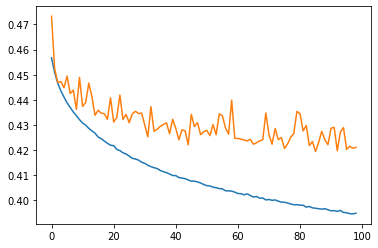

In [24]:
import matplotlib.pyplot as plt
plt.plot(loss_list[1:])
plt.plot(val_loss_list[1:])
plt.savefig('/project/hikaku_db/ziwei/Model_12/loss_plt_state_3.jpg')

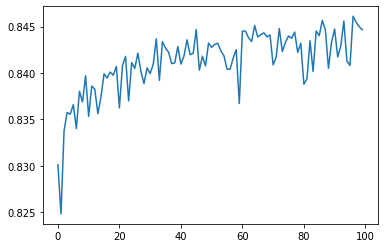

In [25]:
plt.plot(ac_list)
plt.savefig('/project/hikaku_db/ziwei/Model_12/ac_plt_state_3.jpg')

In [26]:
loss_list = pd.DataFrame([loss_list])
val_loss_list = pd.DataFrame([val_loss_list])
ac_list = pd.DataFrame([ac_list])
loss_list.to_csv('/project/hikaku_db/ziwei/Model_12/loss_list_state_3.csv',header=False,index=False)
val_loss_list.to_csv('/project/hikaku_db/ziwei/Model_12/val_loss_list_state_3.csv',header=False,index=False)
ac_list.to_csv('/project/hikaku_db/ziwei/Model_12/ac_list_state_3.csv',header=False,index=False)